In [12]:
from dotenv import load_dotenv
import os
import numpy as np
import branca.colormap as cm

load_dotenv()
ORSkey=os.environ['ORSkey']

In [13]:
import numpy as np
import pandas as pd
import folium
import ast
import openrouteservice as ors
import random

In [14]:
locations = pd.read_csv("../foodstuffs-data/FoodstuffsLocations.csv")
locations.head()

Type    Location           Supermarket        Long        Lat
0  New World      Albany      New World Albany  174.710513 -36.728144
1  New World  Birkenhead  New World Birkenhead  174.711486 -36.811428
2  New World      Botany      New World Botany  174.911491 -36.933883
3  New World  Browns Bay  New World Browns Bay  174.747287 -36.715961
4  New World   Devonport   New World Devonport  174.796193 -36.829510

In [15]:
selected_saturday = pd.read_csv("../linear-program/output/SelectedRoutesSaturday.csv")
selected_saturday.head()

RouteNum                                              Route   TruckType  \
0     r105  ['Warehouse', 'New World Papakura', "Pak 'n Sa...  OwnedTruck   
1     r133  ['Warehouse', 'New World Mt Roskill', 'New Wor...  OwnedTruck   
2    r1563  ['Warehouse', "Pak 'n Save Wairau Road", 'New ...  OwnedTruck   
3    r1568  ['Warehouse', 'New World Birkenhead', 'Four Sq...  OwnedTruck   
4    r1915  ['Warehouse', 'Four Square Alberton', 'New Wor...  OwnedTruck   

   RouteCost  
0   294.5460  
1   192.6705  
2   332.3620  
3   432.4040  
4   260.3805

In [16]:
selected_weekday = pd.read_csv("../linear-program/output/SelectedRoutesWeekday.csv")
selected_weekday.head()

RouteNum                                              Route   TruckType  \
0     r109  ['Warehouse', 'Four Square Glen Eden', "Pak 'n...  OwnedTruck   
1     r122  ['Warehouse', "Pak 'n Save Lincoln Road", 'War...  OwnedTruck   
2     r124  ['Warehouse', "Pak 'n Save Westgate", 'Warehou...  OwnedTruck   
3      r14  ['Warehouse', 'Four Square Everglade', 'New Wo...  OwnedTruck   
4     r156  ['Warehouse', 'Four Square Alberton', 'Four Sq...  OwnedTruck   

    RouteCost  
0  317.127667  
1  104.192500  
2  118.685417  
3  271.918833  
4  387.919750

In [17]:
def initialise_map(locations):
    """ Initialise map and plot store locations.

        Parameters
        ----------
        locations : dataframe
            Location of stores.
        
        Returns
        -------
        m : object
            Map object with plotted store locations.
    """
    coords = locations[['Long', 'Lat']] # Mapping packages work with Long, Lat arrays
    coords = coords.to_numpy().tolist() # Make the arrays into a list of lists.
    # Folium, however, requires Lat, Long arrays - so a reversal is needed.
    # coords[0] is the warehouse
    m = folium.Map(location = list(reversed(coords[2])), zoom_start=10.25)
    for i in range(len(locations)):
        if locations.Type[i] == "Four Square":
            icon_url = "store_green.png"
        elif locations.Type[i] == "New World":
            icon_url = "store_red.png"
        elif locations.Type[i] == "Pak 'n Save":
            icon_url = "store_orange.png"
        elif locations.Type[i] == "Warehouse":
            icon_url = "warehouse.png"
        icon = folium.features.CustomIcon(icon_url, icon_size=(16, 16))
        folium.Marker(
            list(reversed(coords[i])),
            popup = locations.Supermarket[i],
            icon = icon # folium.Icon(color = iconCol)
        ).add_to(m)
    return m

In [18]:
def find_driving_route(coords):
    """ Find driving route between stores in a route.

        Parameters
        ----------
        coords : list
            List of coordinates of store locations within route.
        
        Returns
        -------
        object
            Driving route.
    """
    client = ors.Client(key=ORSkey)
    
    return client.directions(
        coordinates = coords,
        profile = 'driving-hgv', # can be driving-car, driving-hgv, etc.
        format='geojson',
        validate = False
    )

In [19]:
def plot_routes(locations, routes, m):
    """ Plot driving routes of selected routes between stores.

        Parameters
        ----------
        locations : dataframe
            Locations of nodes.
        routes : dataframe
            Selected routes.
        m : object
            Map object.
        
        Returns
        -------
        m : object
            Map object with plotted routes.
    """
    colour_choices = cm.LinearColormap(
        colors=["green", "blue", "purple"],
        vmin=min(routes.RouteCost),
        vmax=max(routes.RouteCost)
    )

    for i in routes.index:
        route = ast.literal_eval(routes.Route[i])
        
        coord_list = []
        for node in route:
            coord = locations[locations.Supermarket==node][['Long', 'Lat']]
            coord = coord.to_numpy().tolist()
            coord_list.append(coord[0])
        
        driving_route = find_driving_route(coord_list)
        coordinates = driving_route['features'][0]['geometry']['coordinates']
        folium.PolyLine(
            locations=[list(reversed(coord)) for coord in coordinates],
            opacity=0.5,
            weight=4,
            color=colour_choices(routes.RouteCost[i])
        ).add_to(m)
    return m


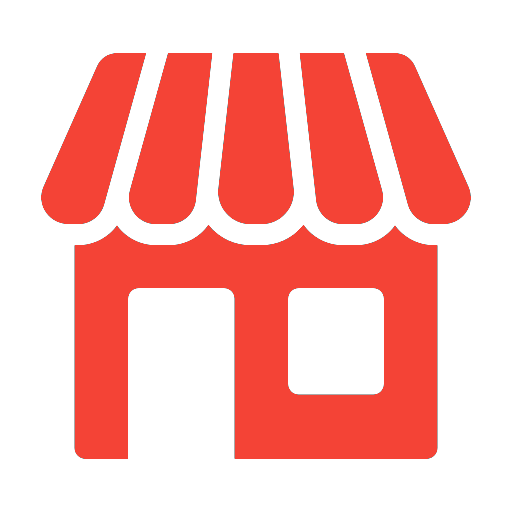
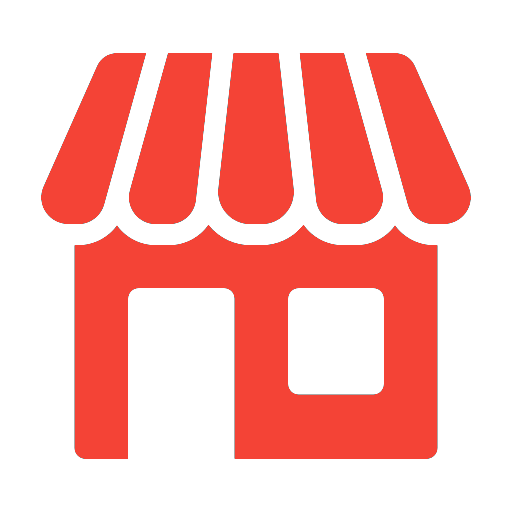
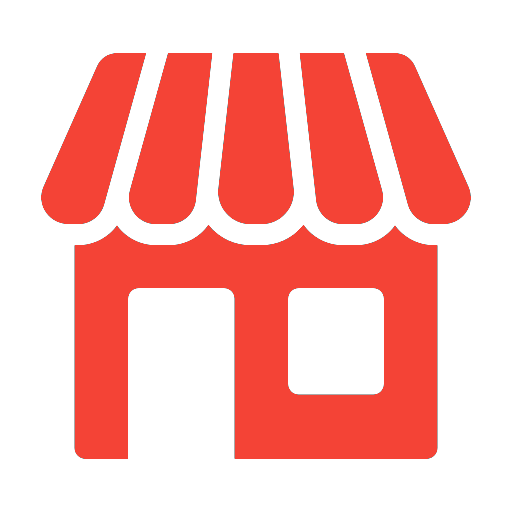
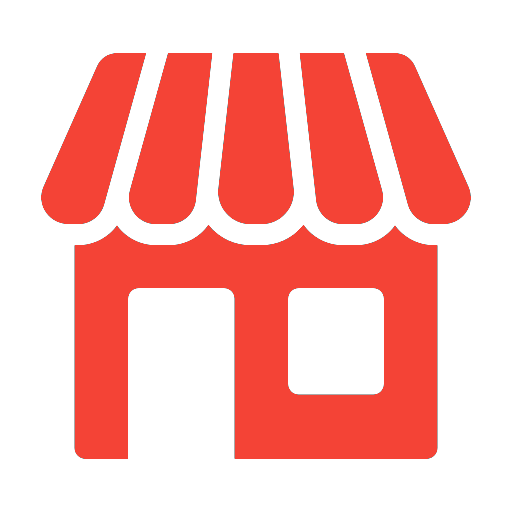
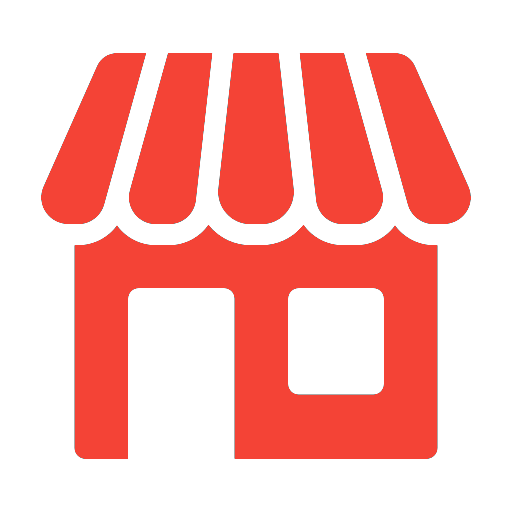
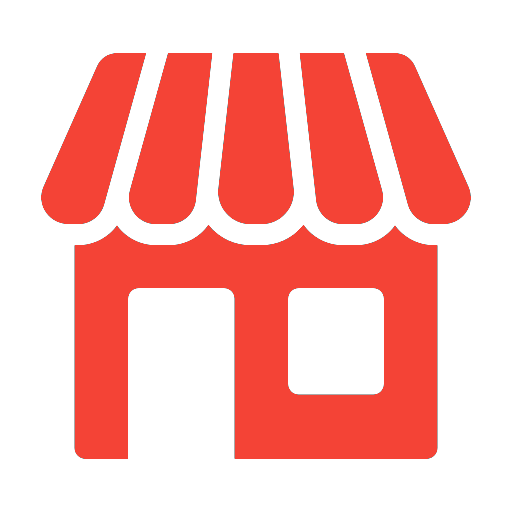
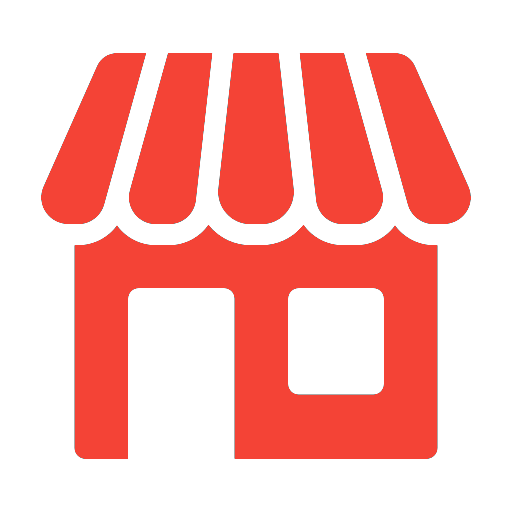
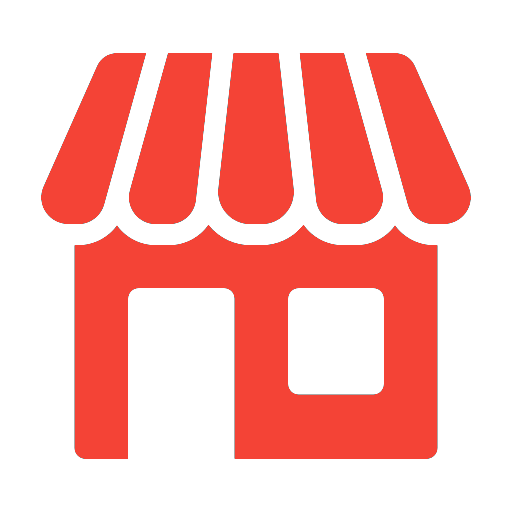
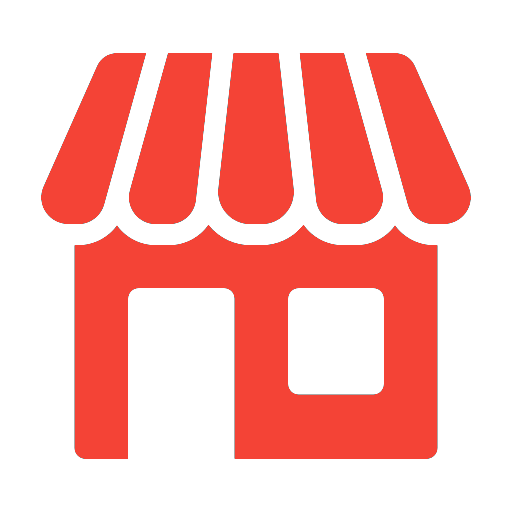
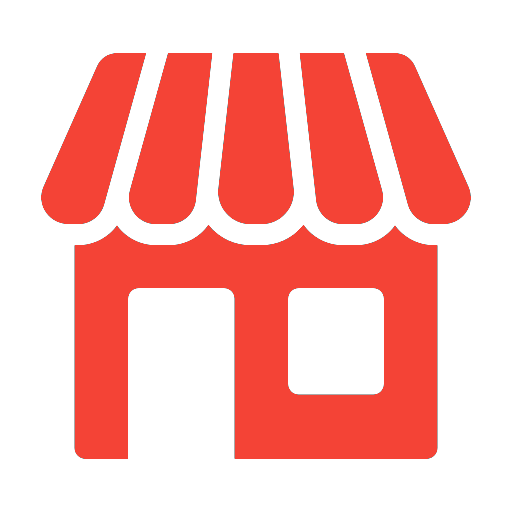
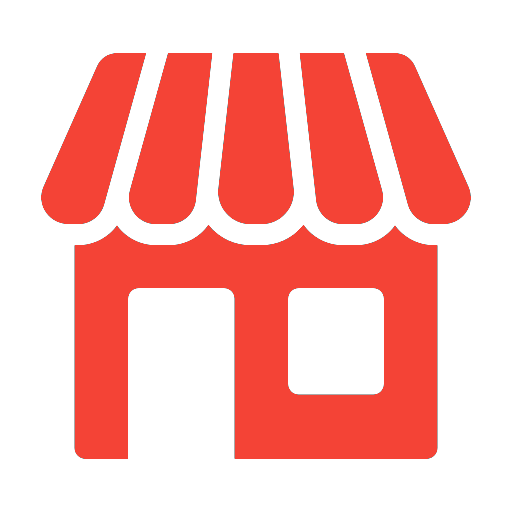
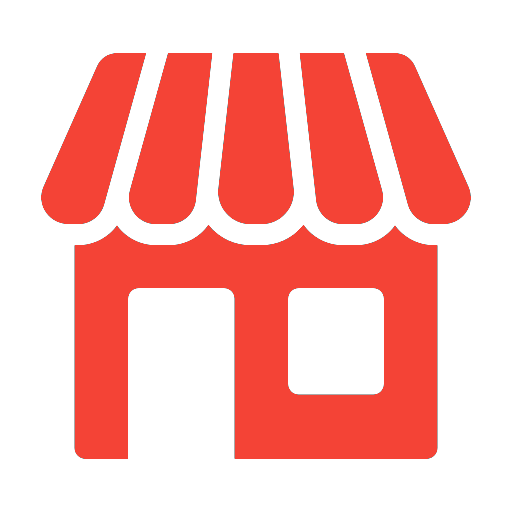
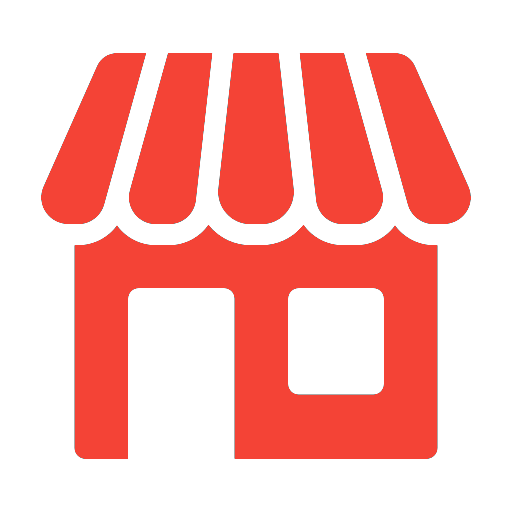
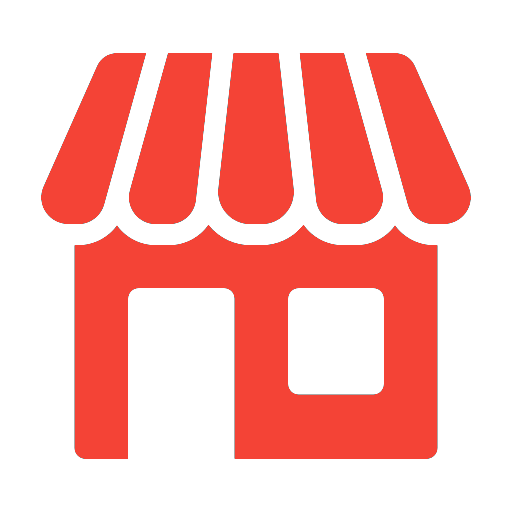
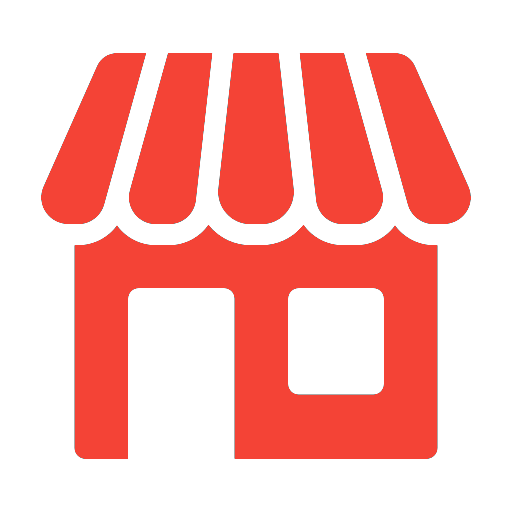
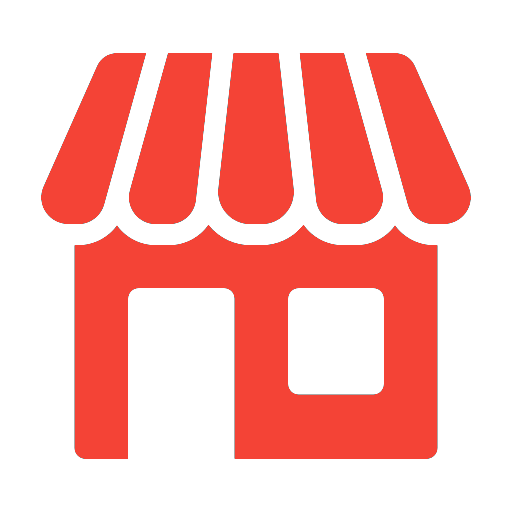
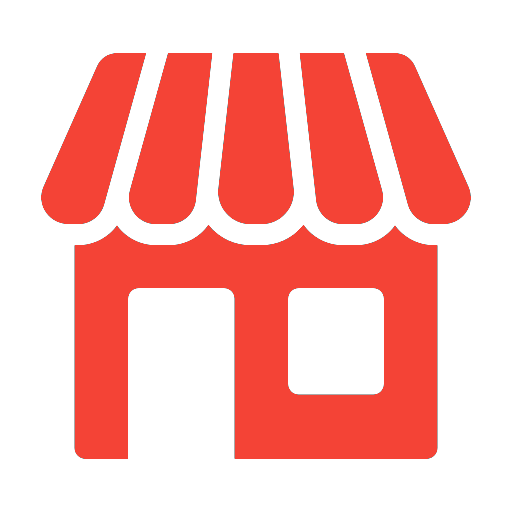
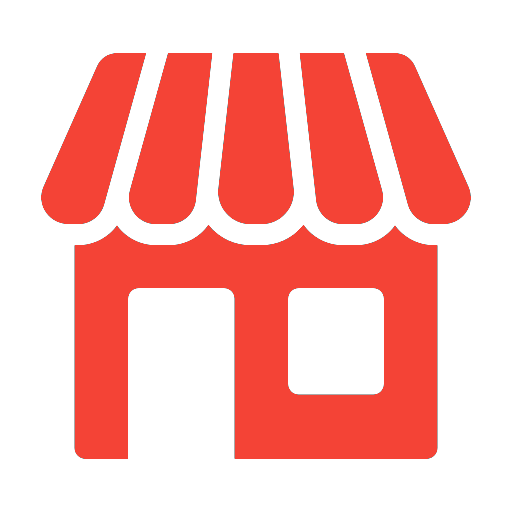
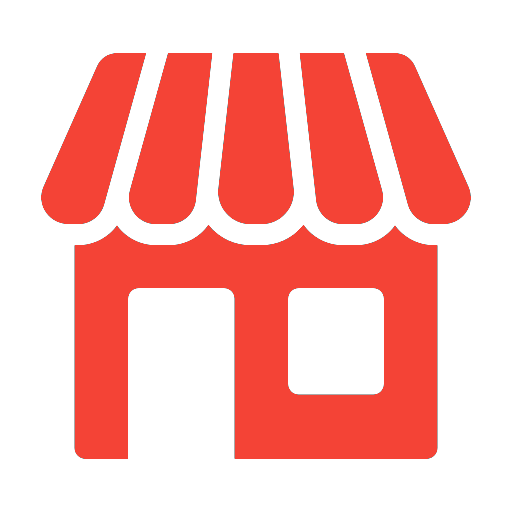
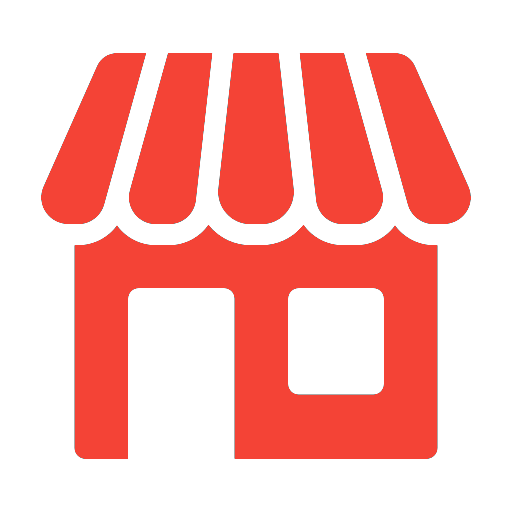
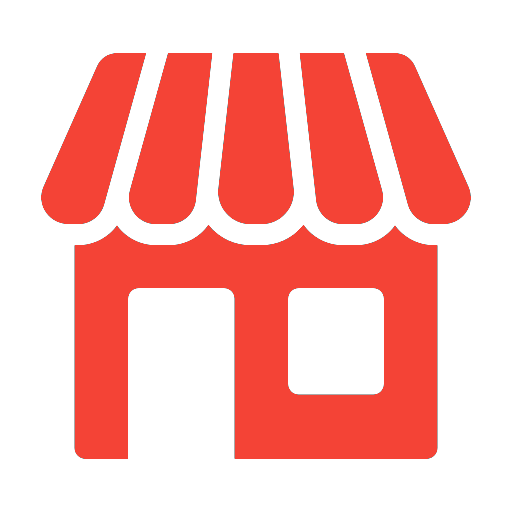
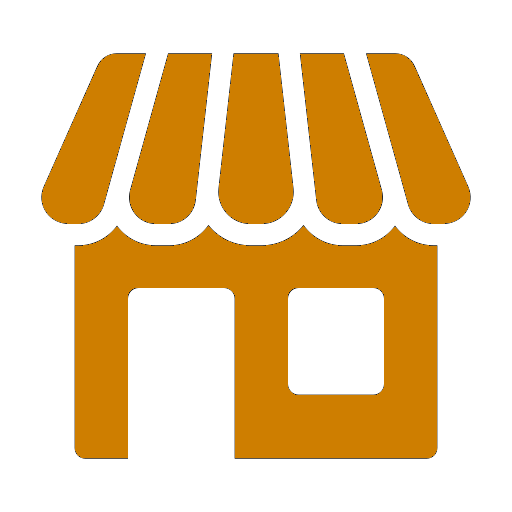
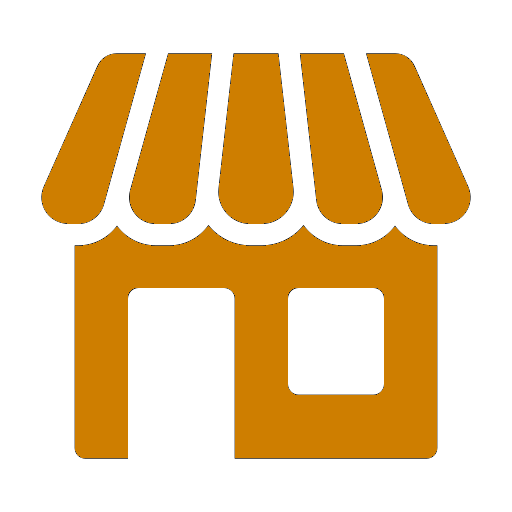
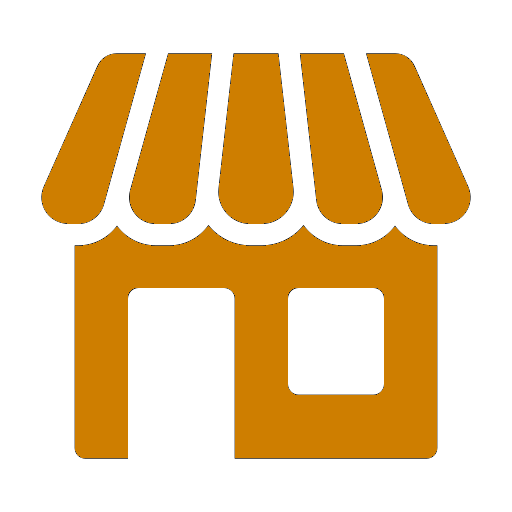
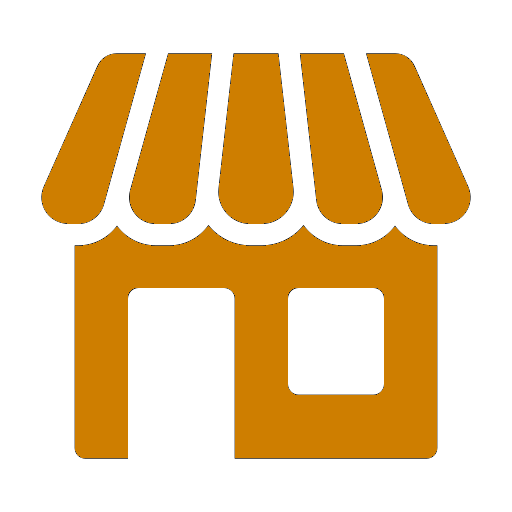
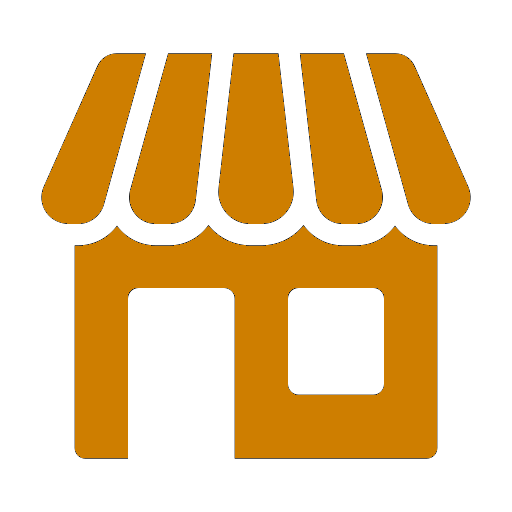
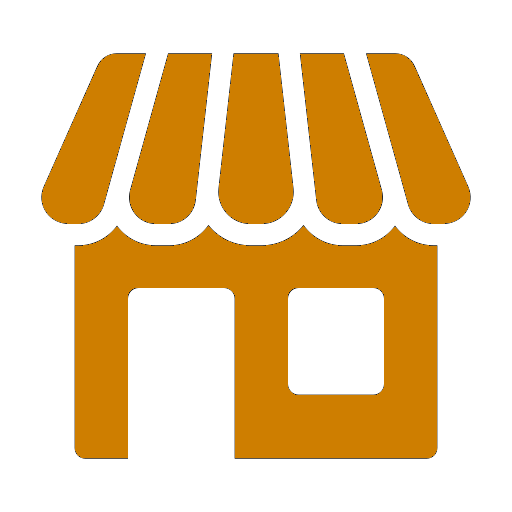
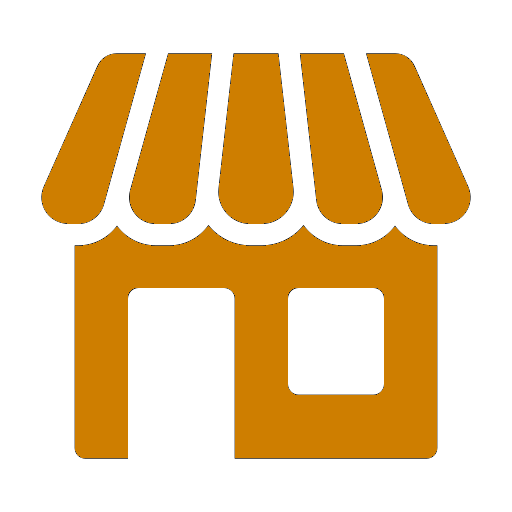
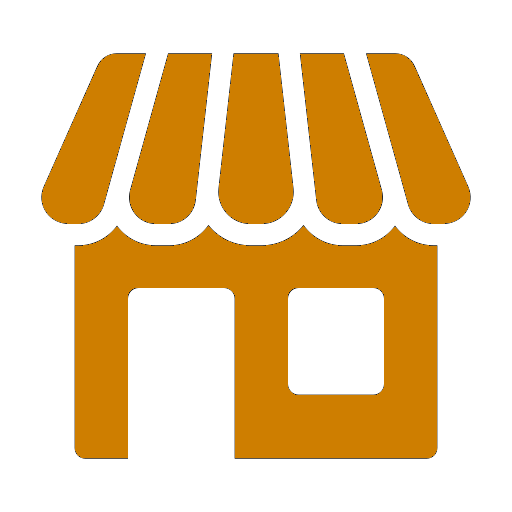
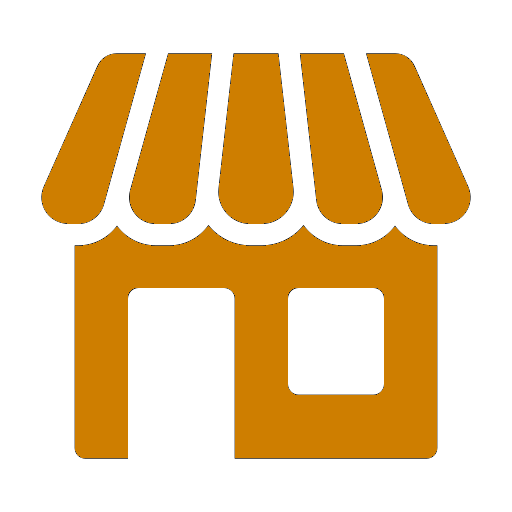
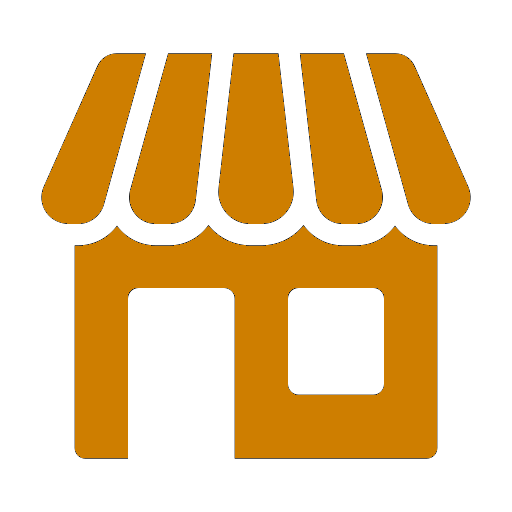
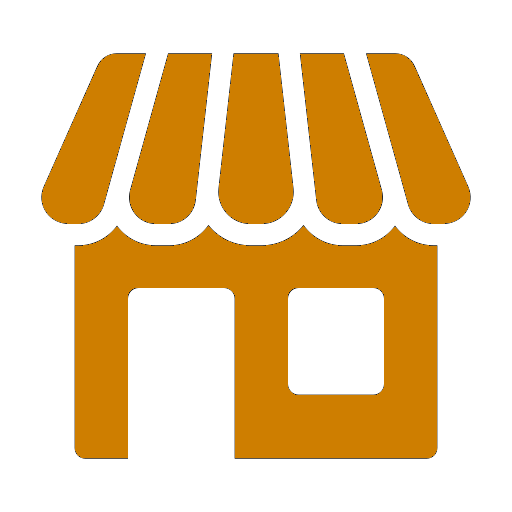
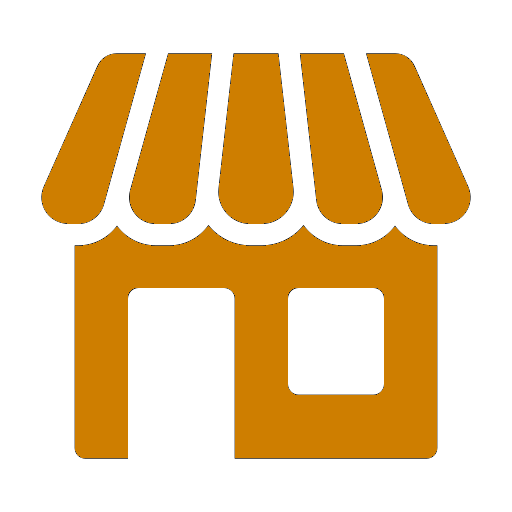
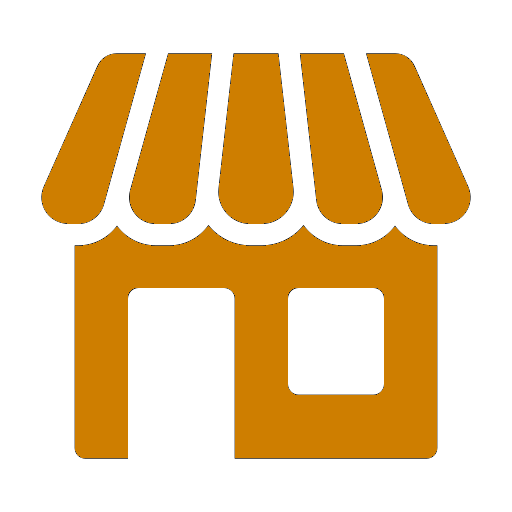
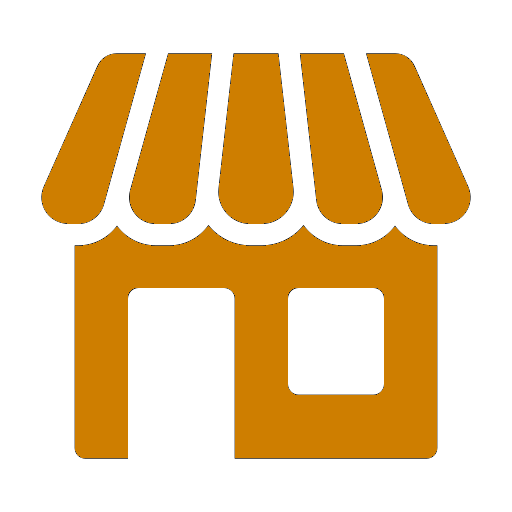
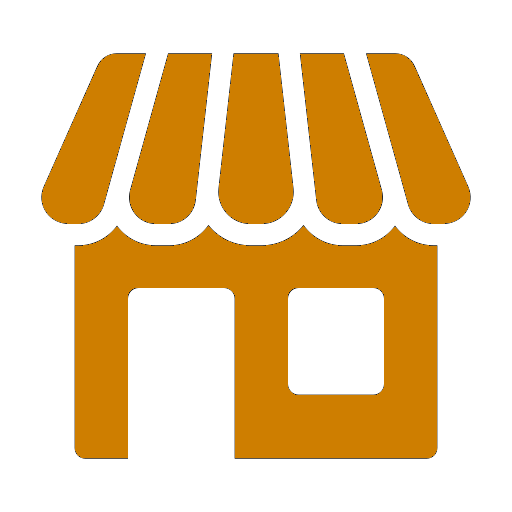
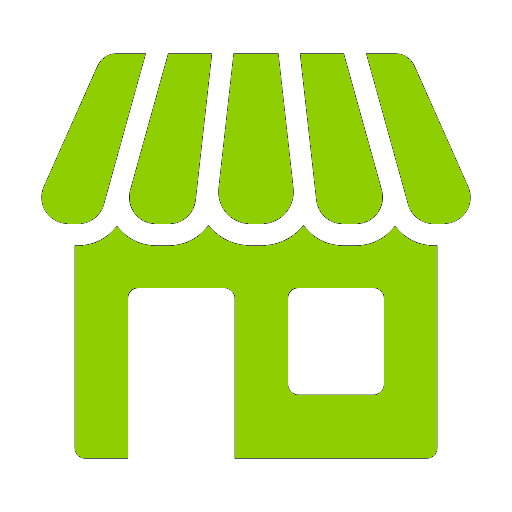
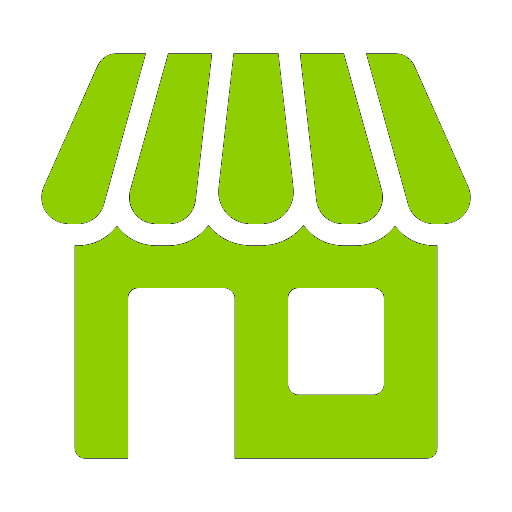
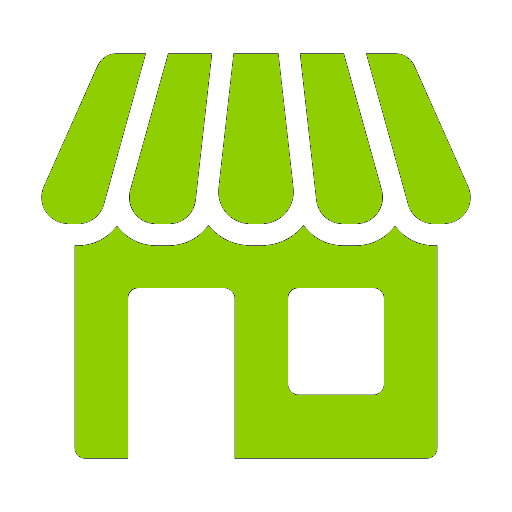
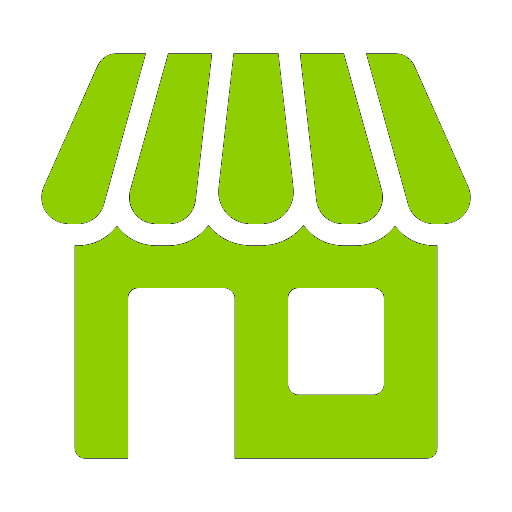
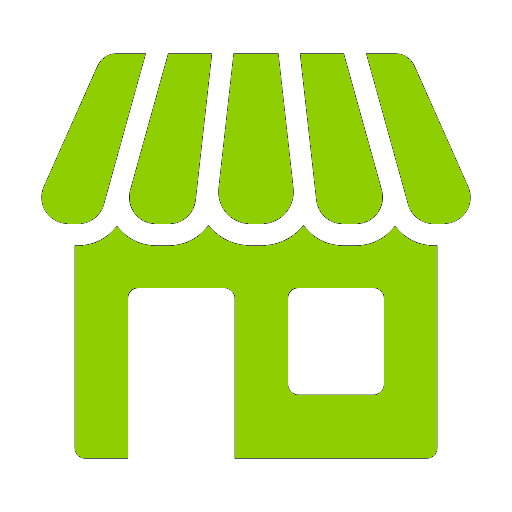
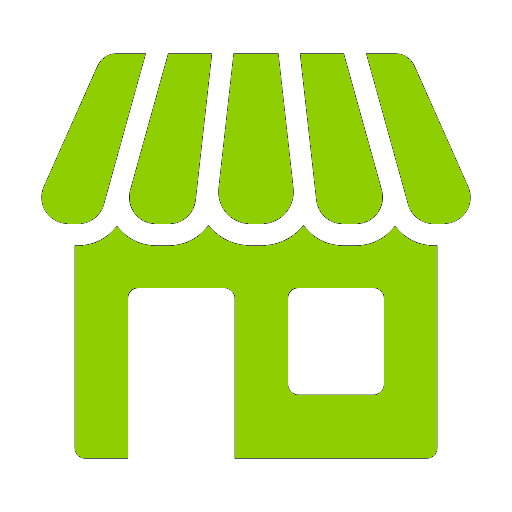
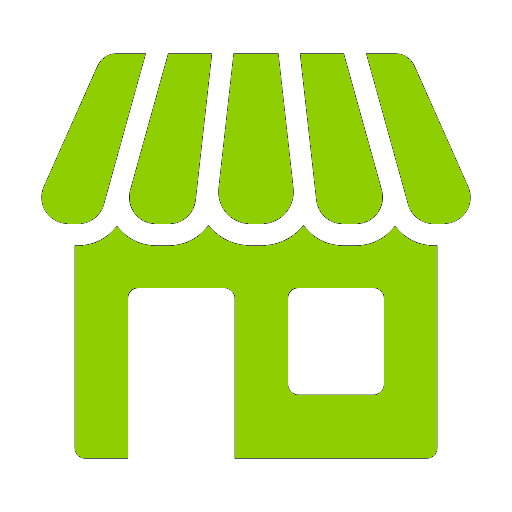
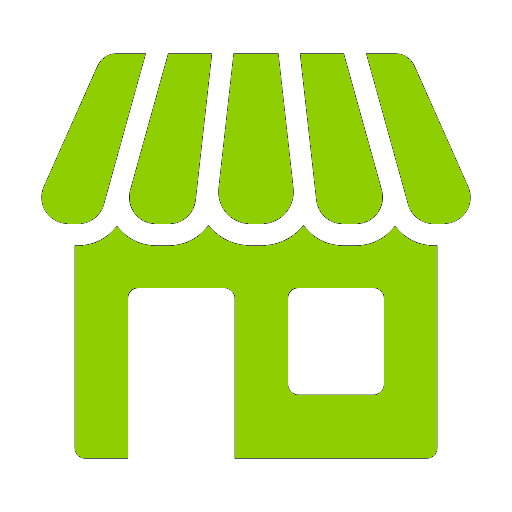
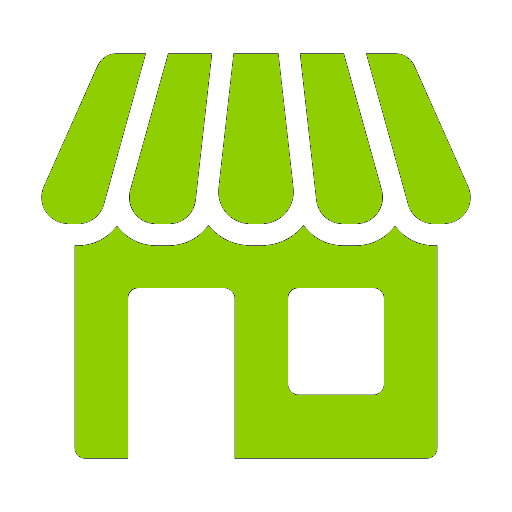
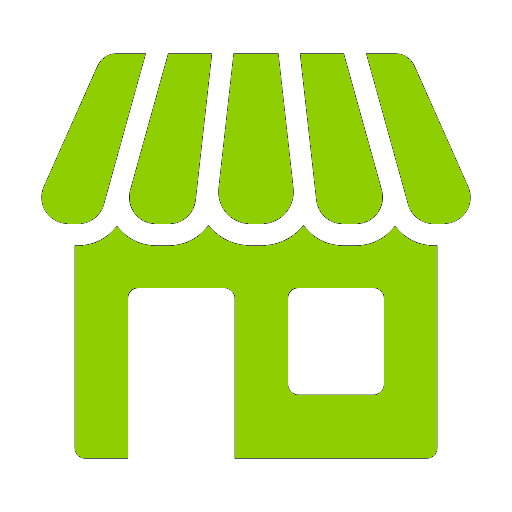
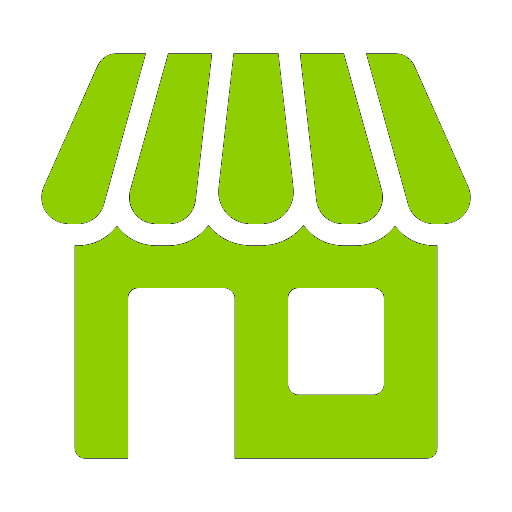
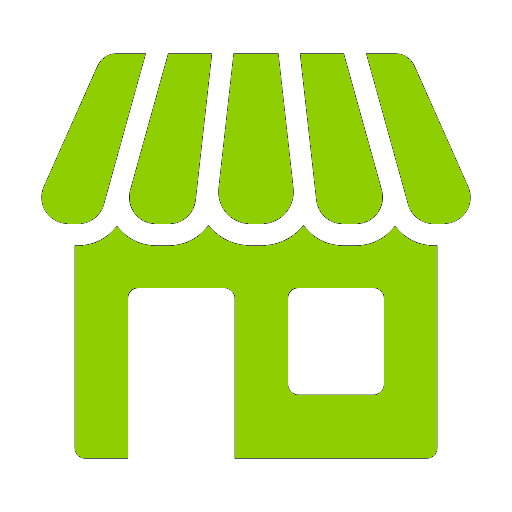
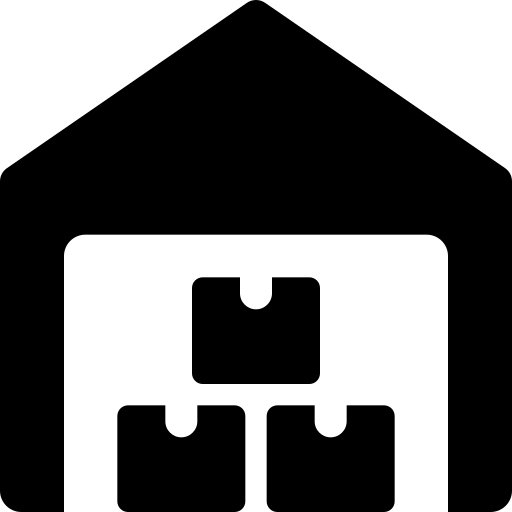

In [20]:
initialise_map(locations)


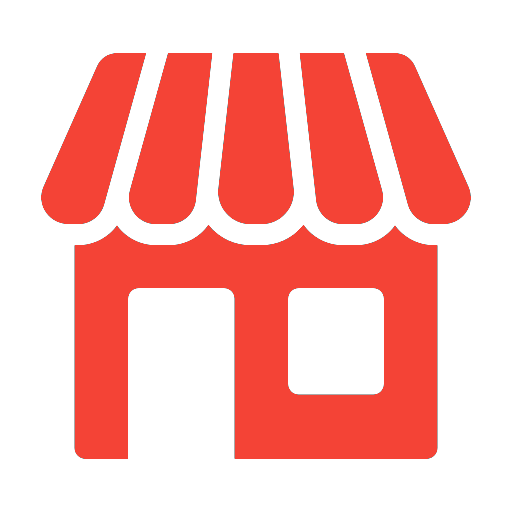
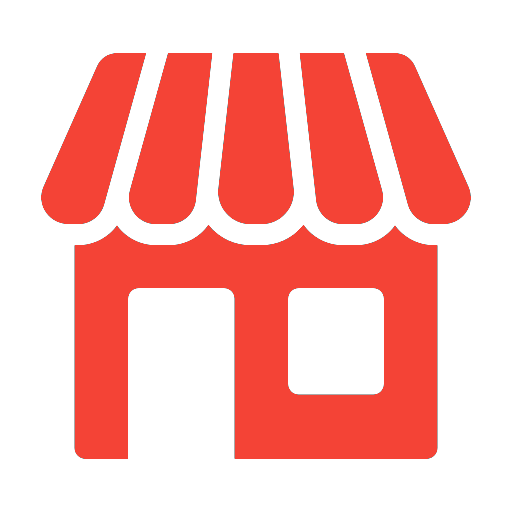
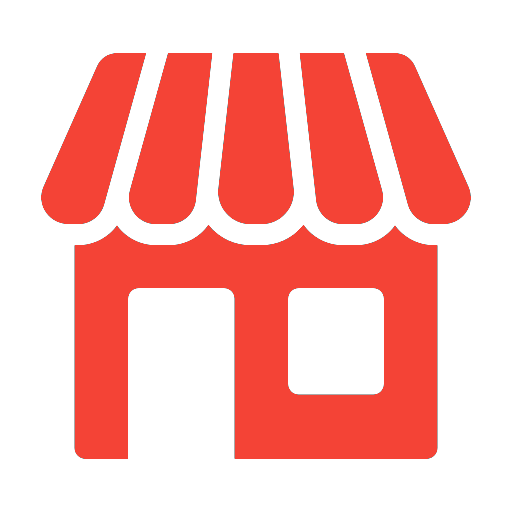
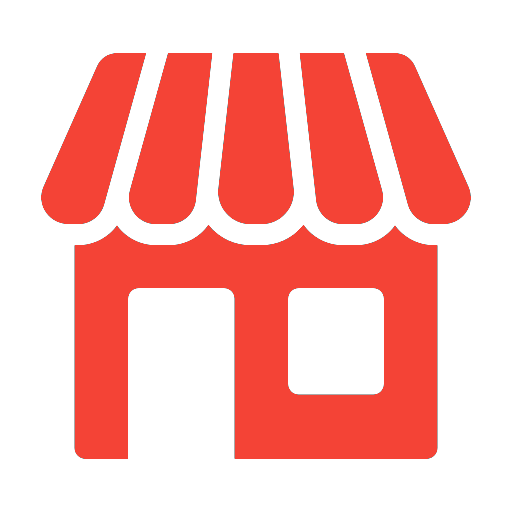
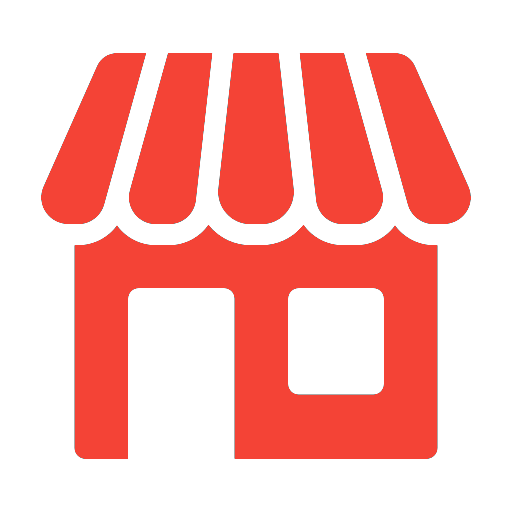
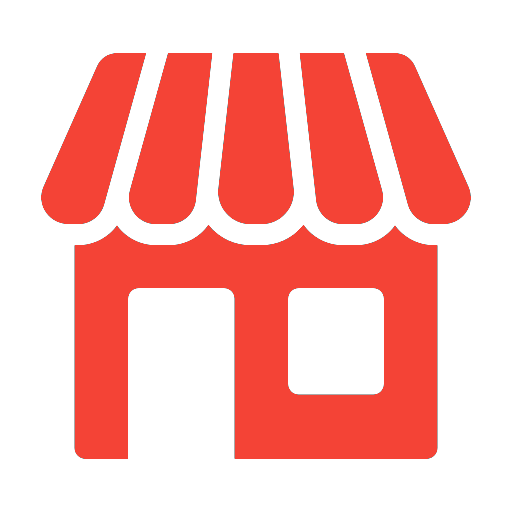
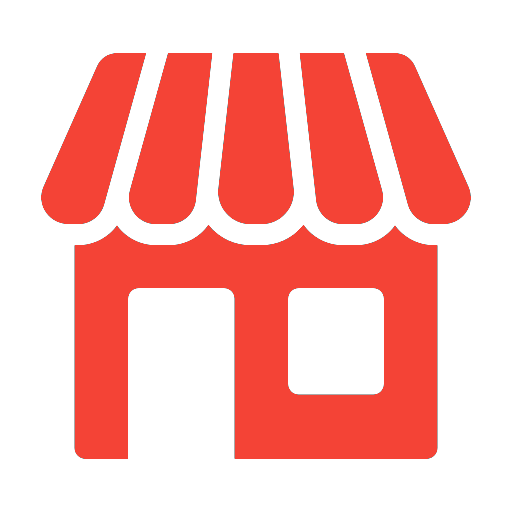
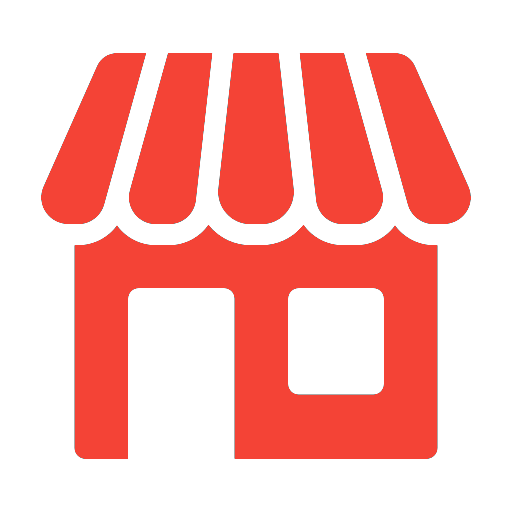
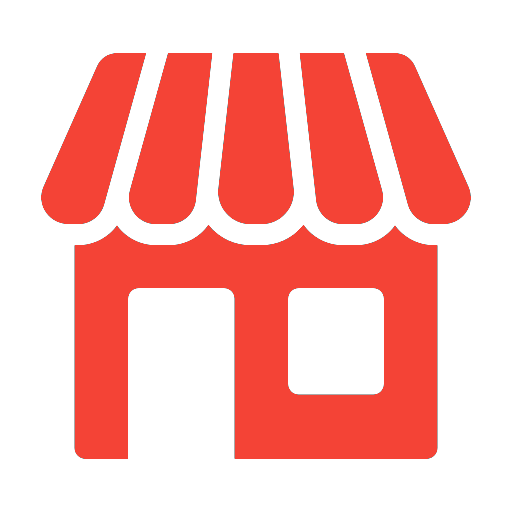
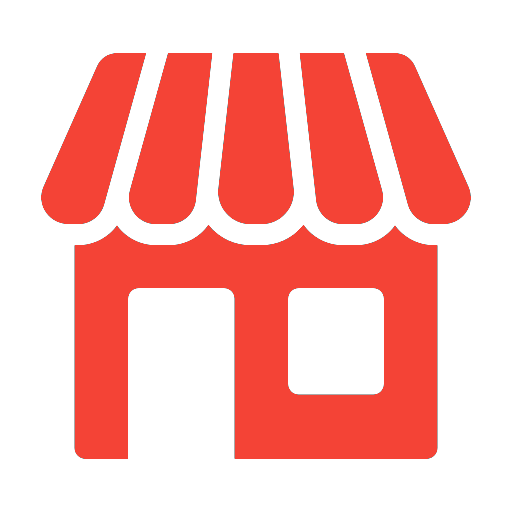
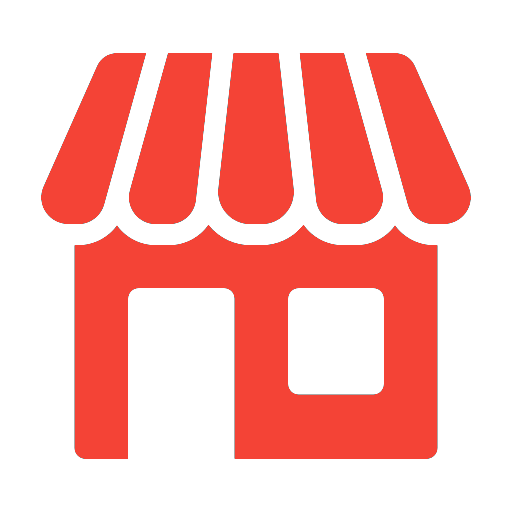
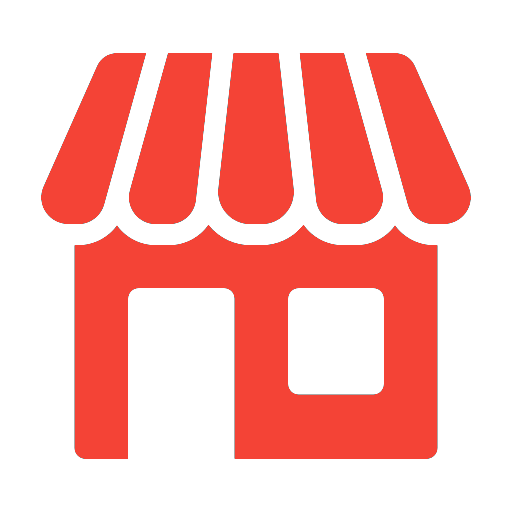
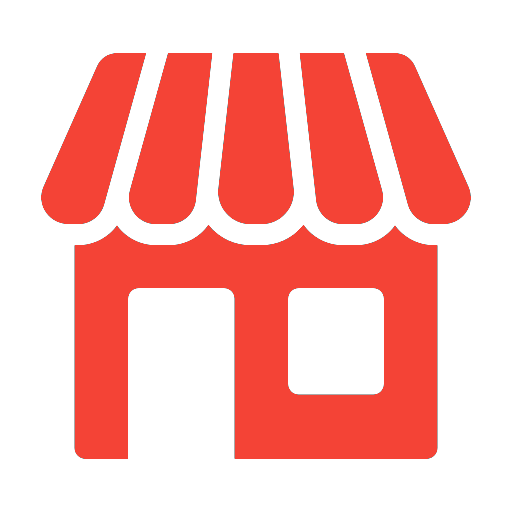
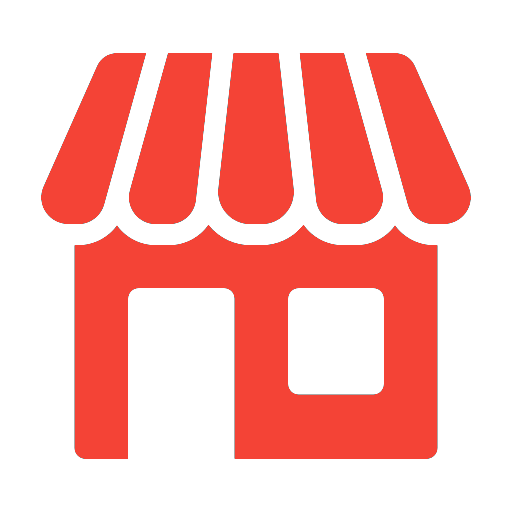
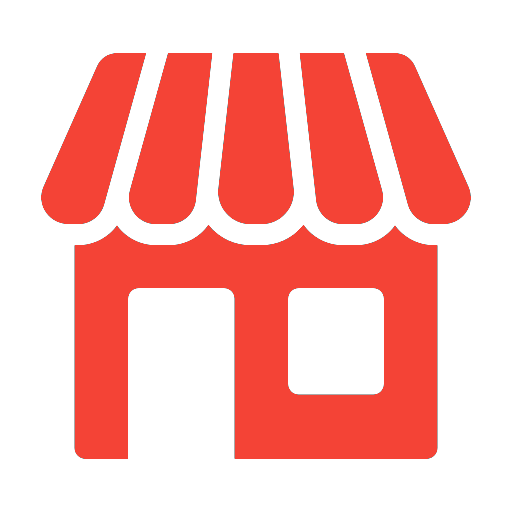
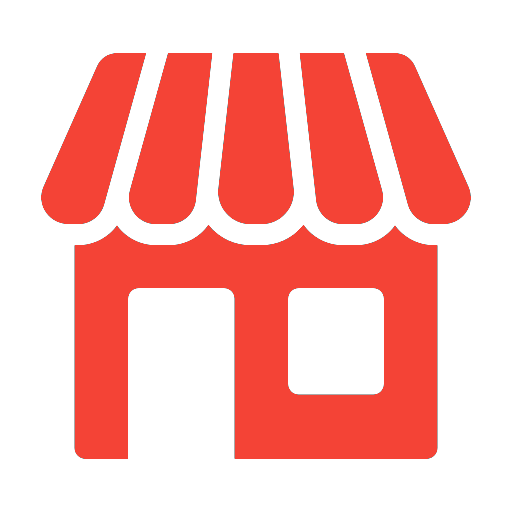
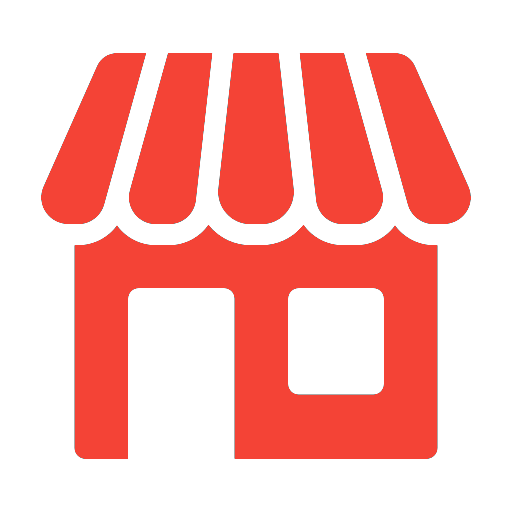
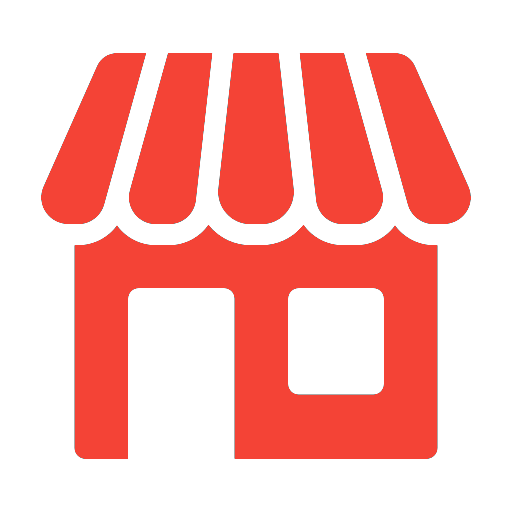
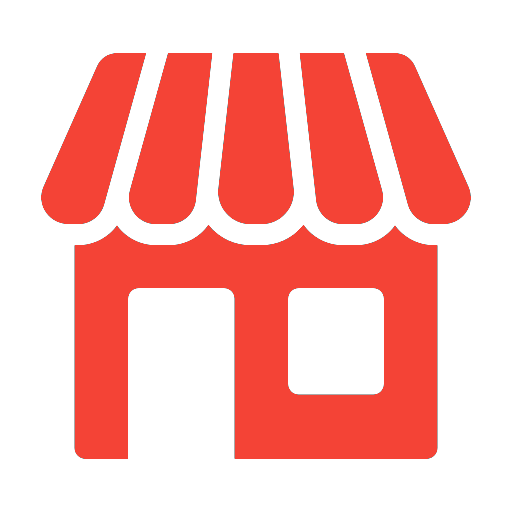
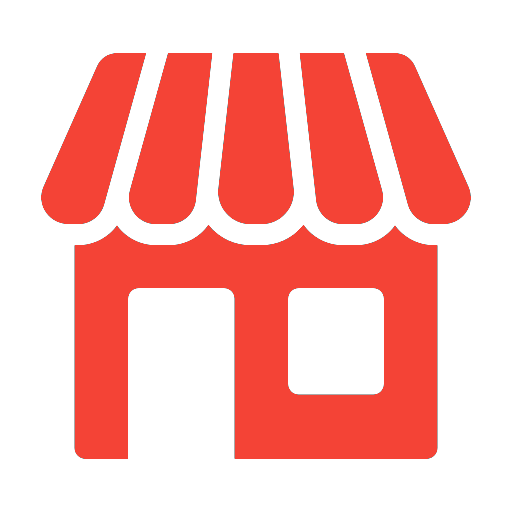
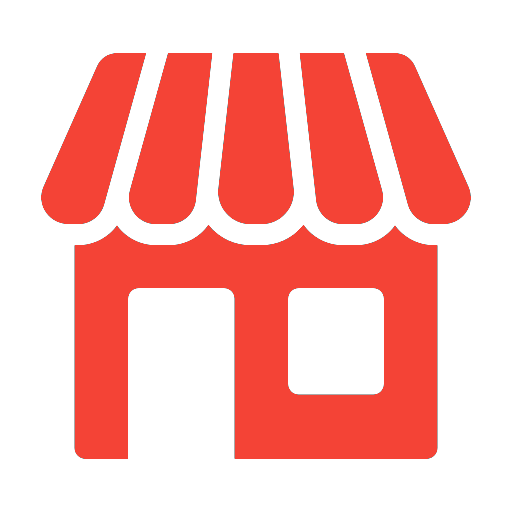
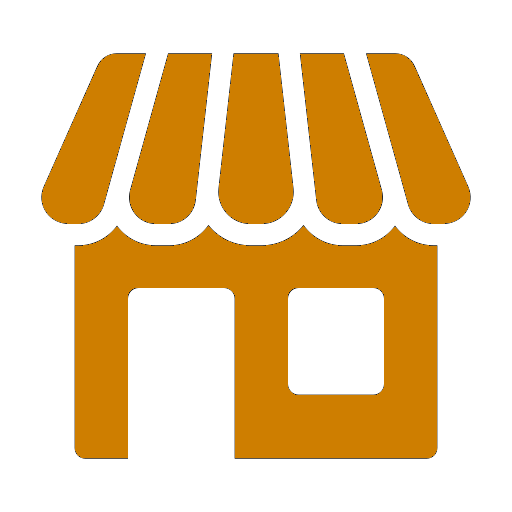
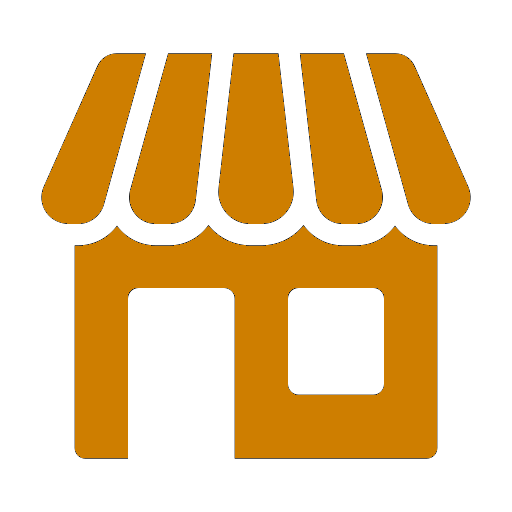
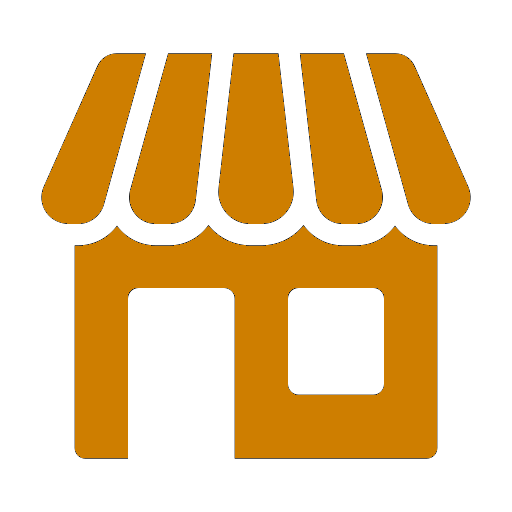
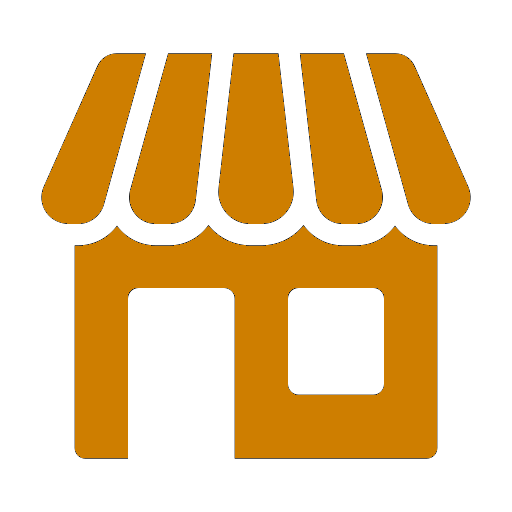
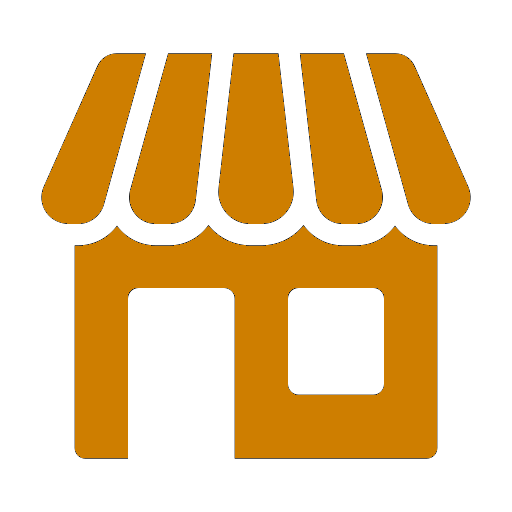
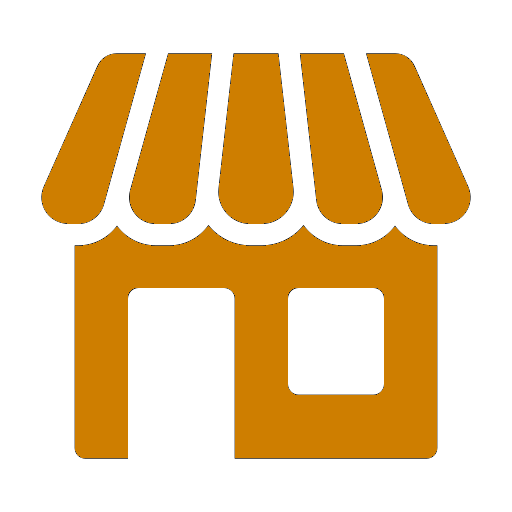
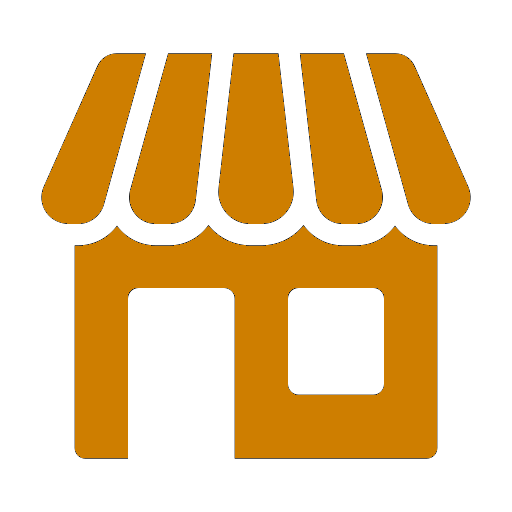
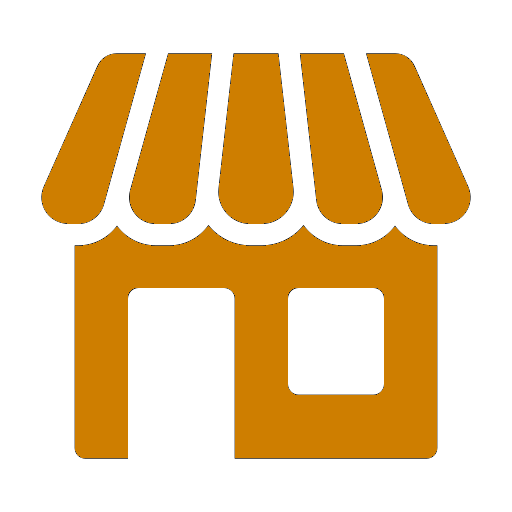
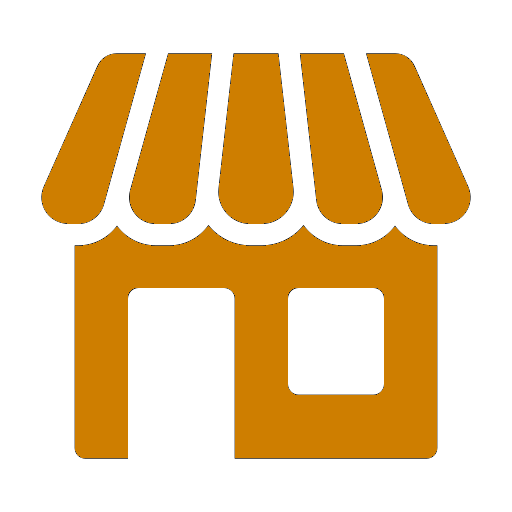
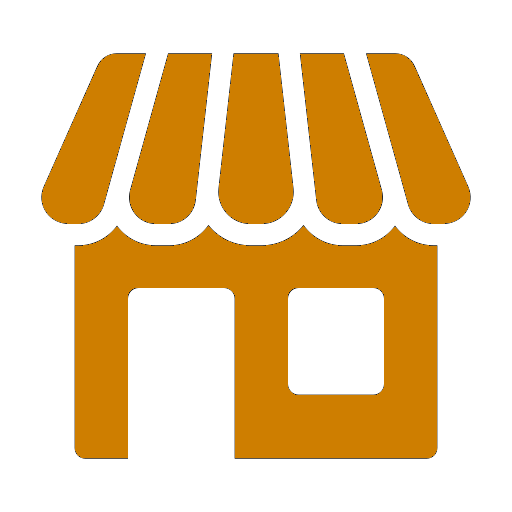
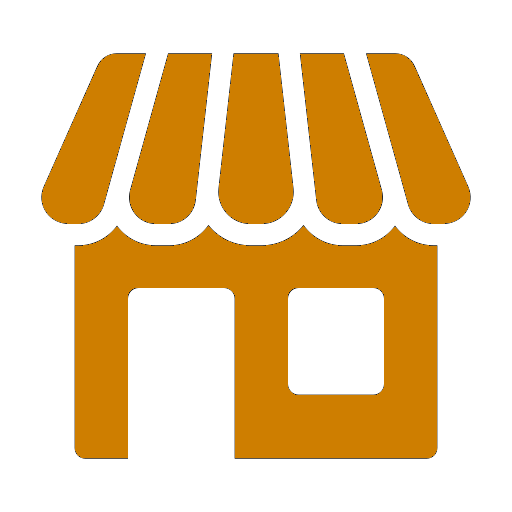
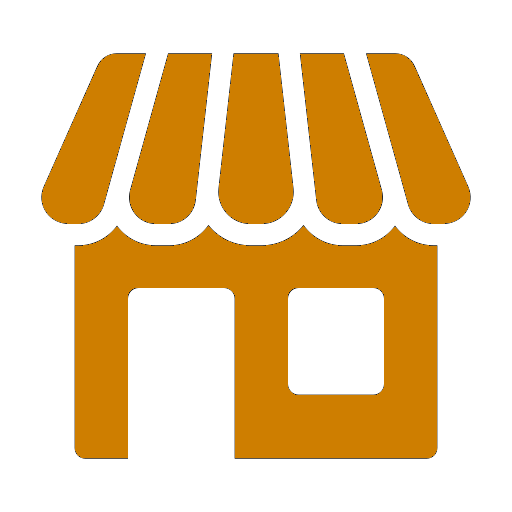
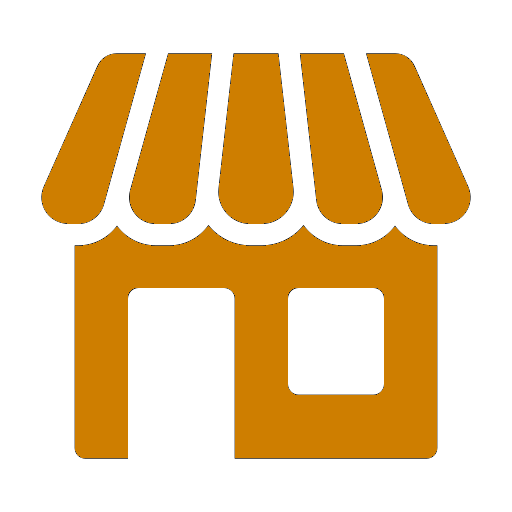
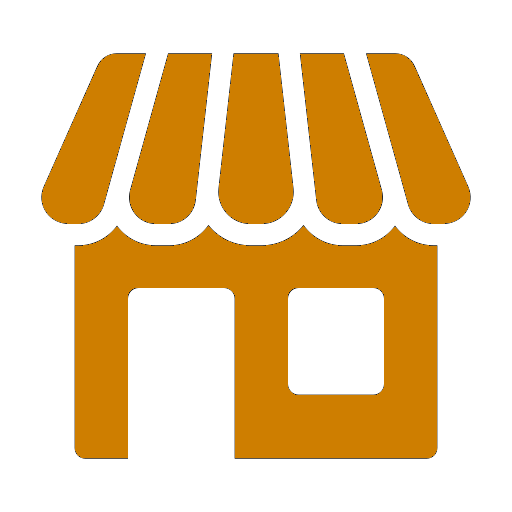
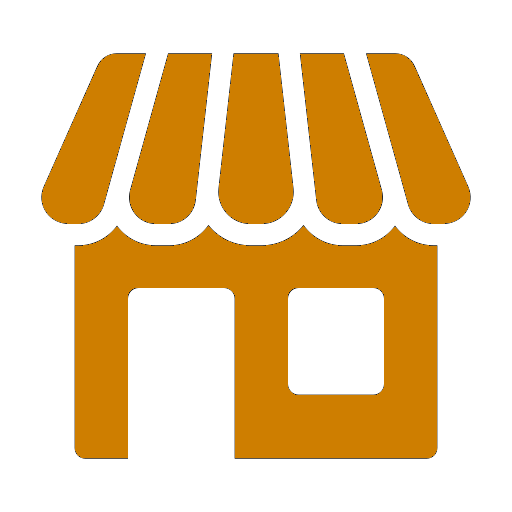
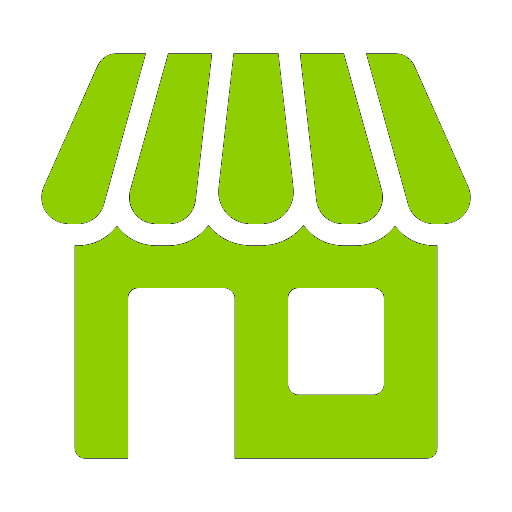
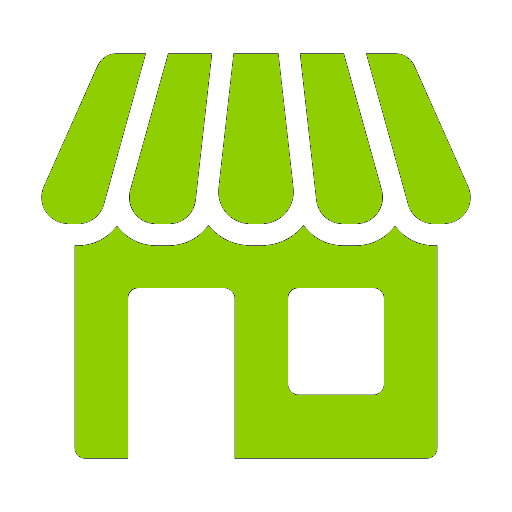
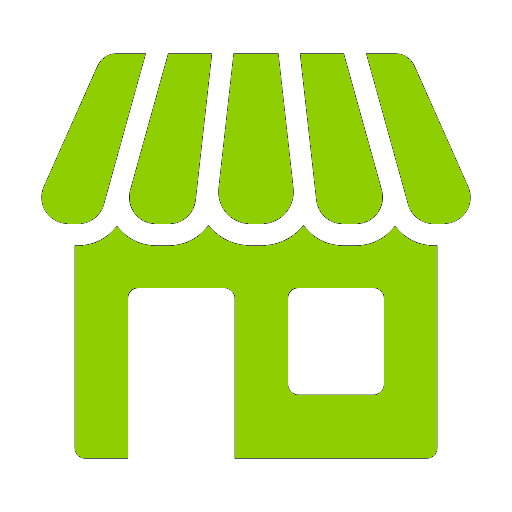
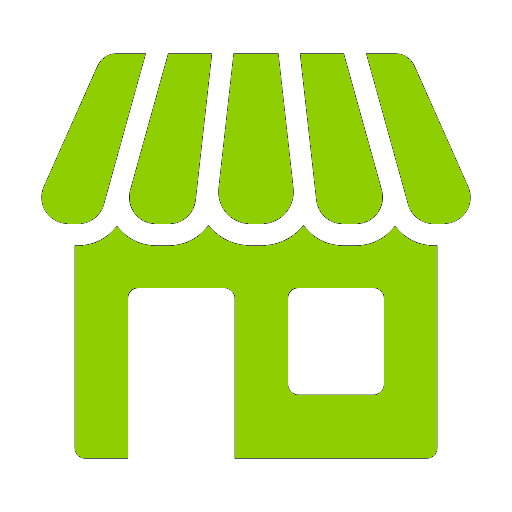
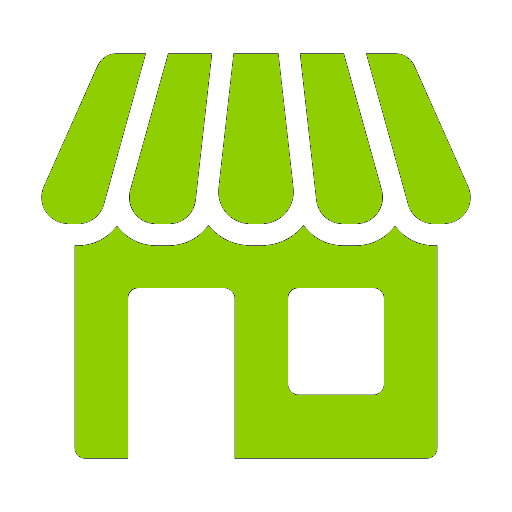
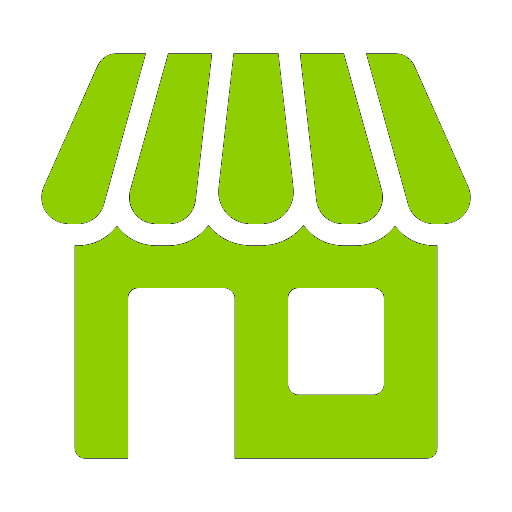
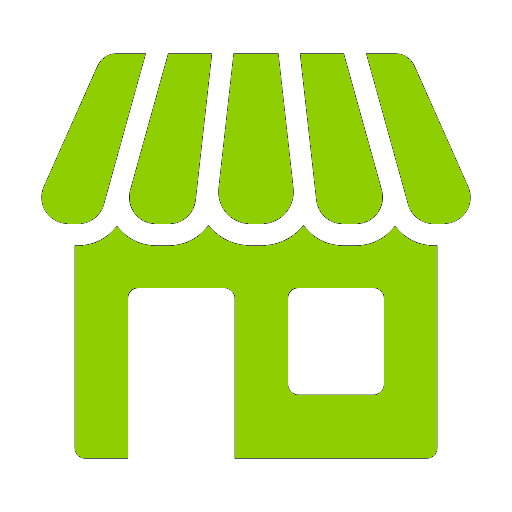
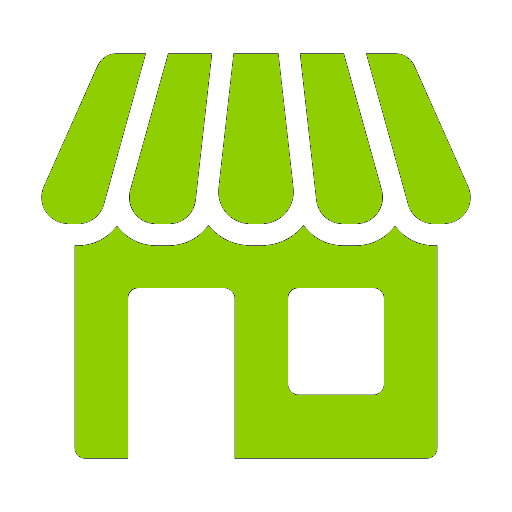
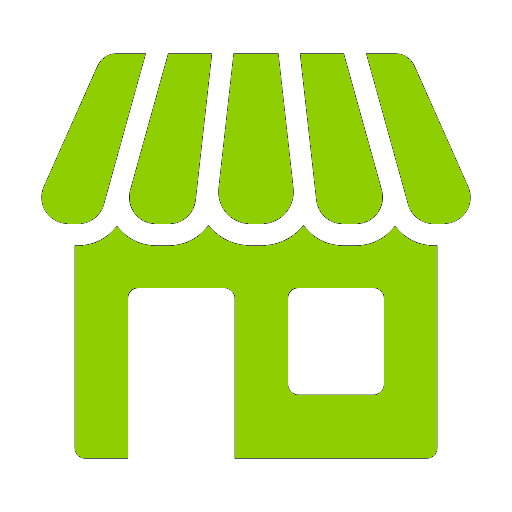
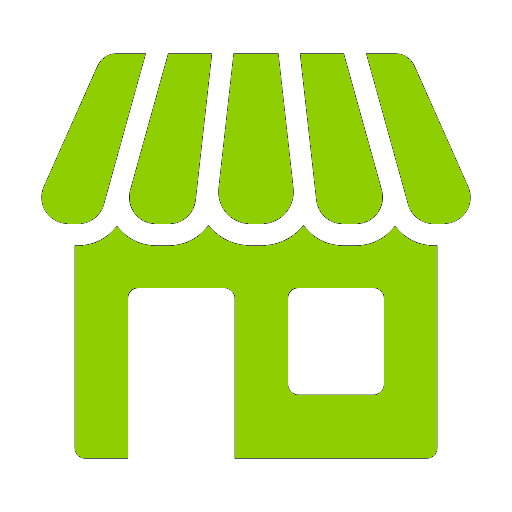
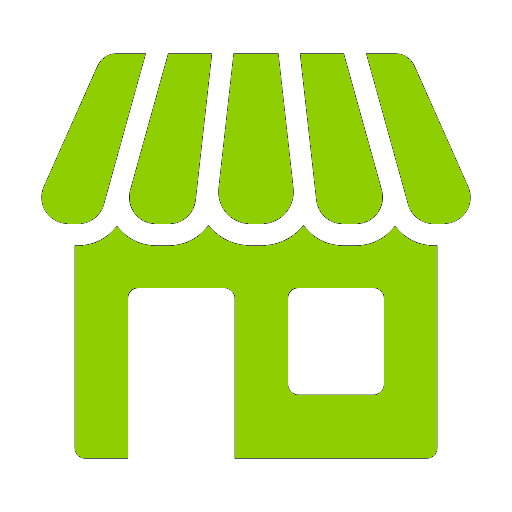
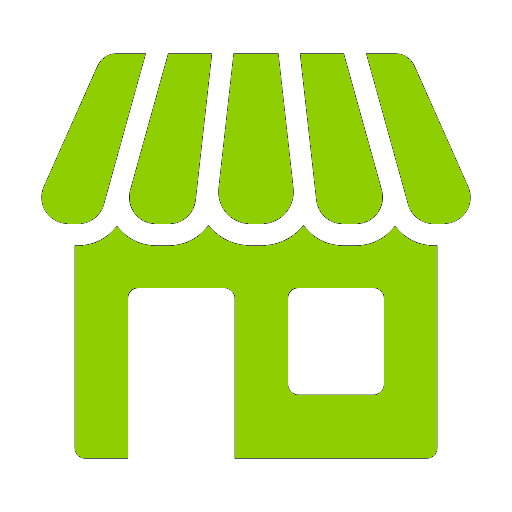
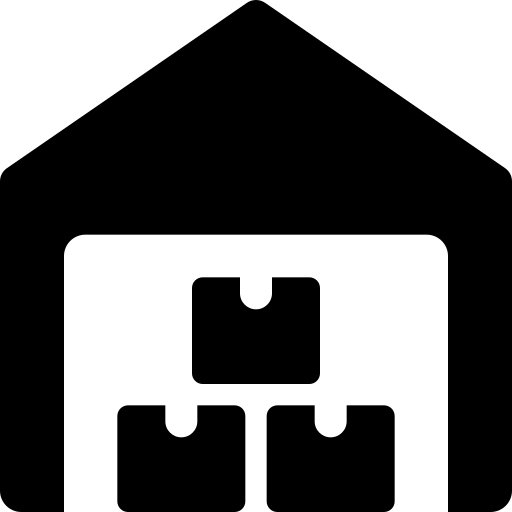

In [21]:
saturday_map = initialise_map(locations)
plot_routes(locations, selected_saturday, saturday_map)


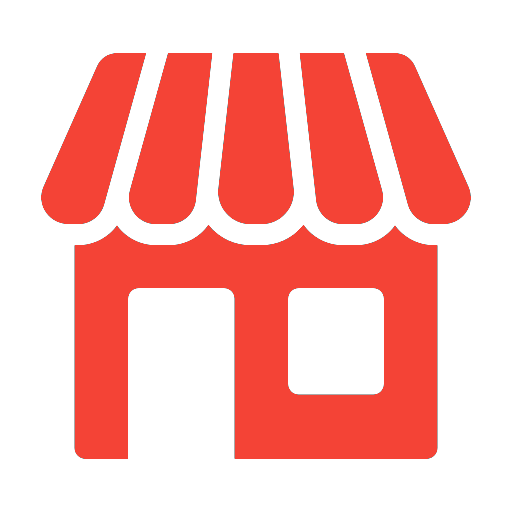
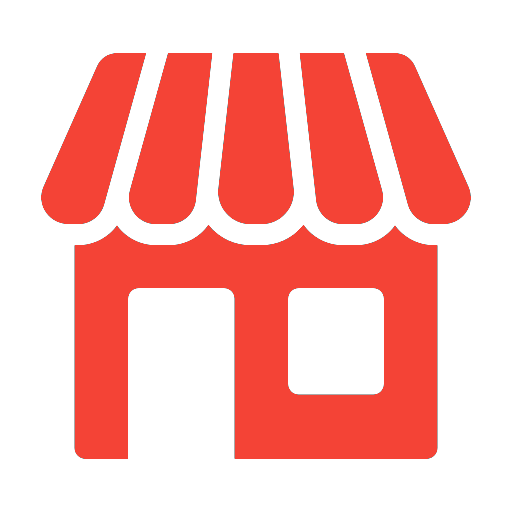
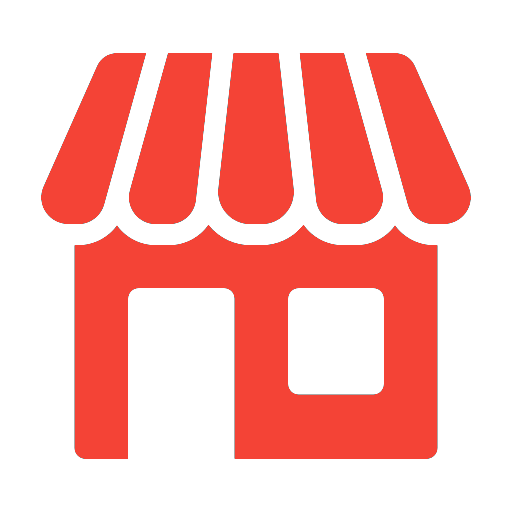
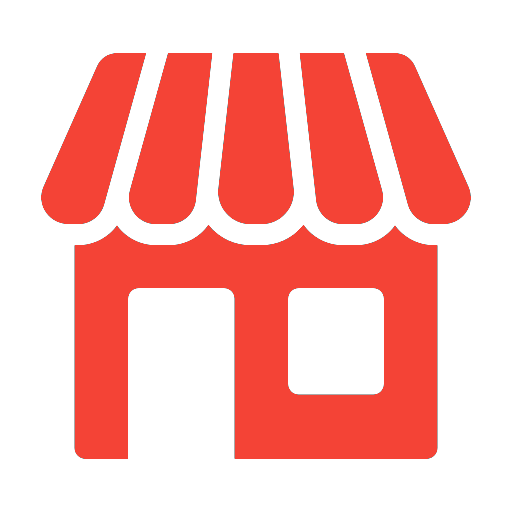
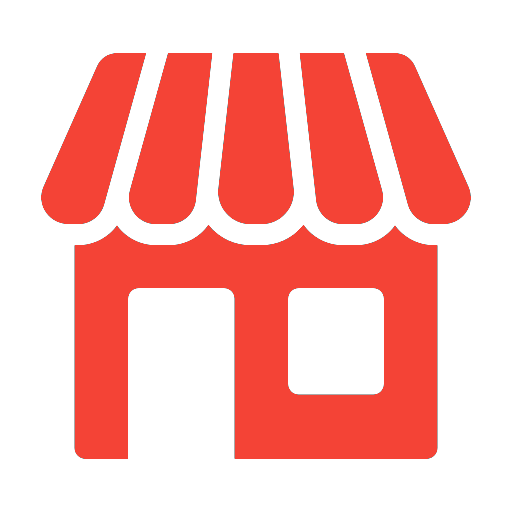
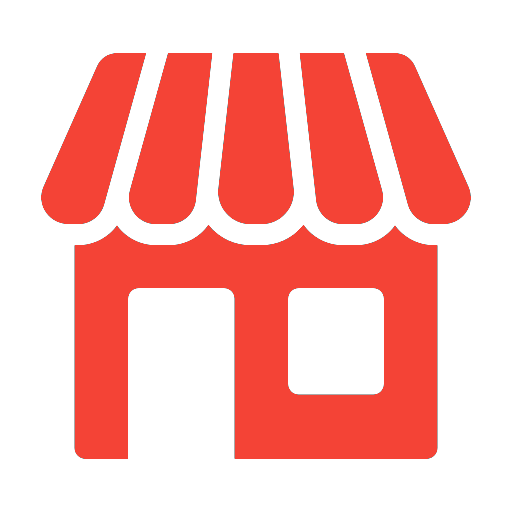
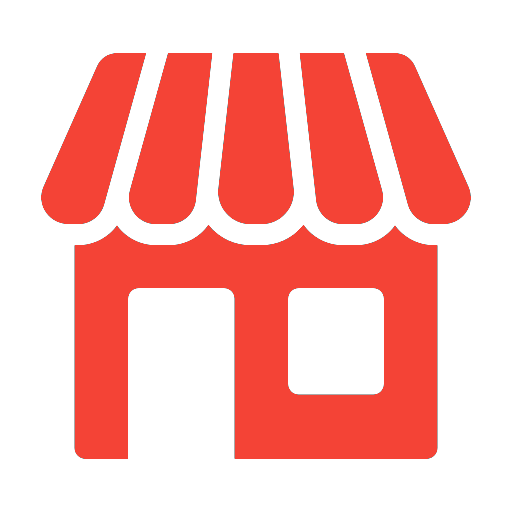
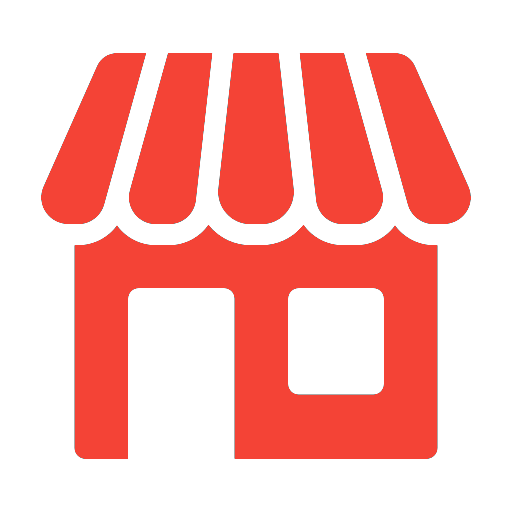
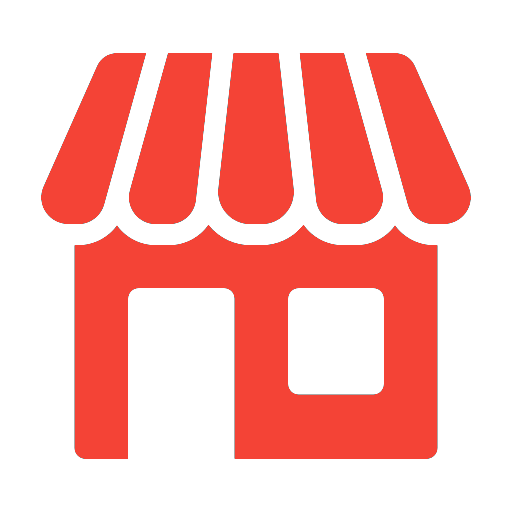
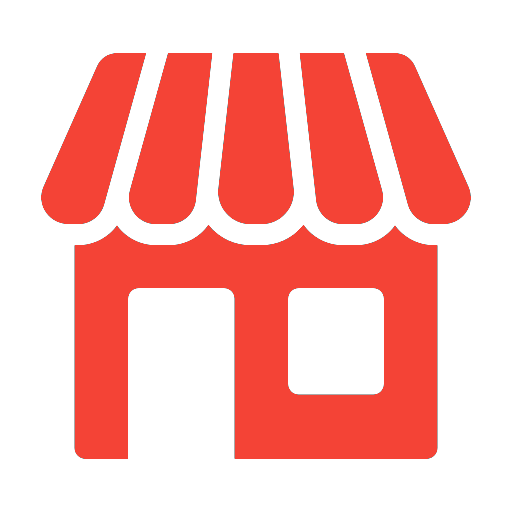
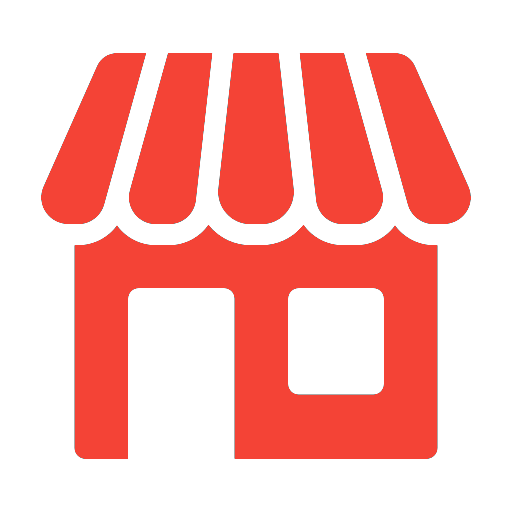
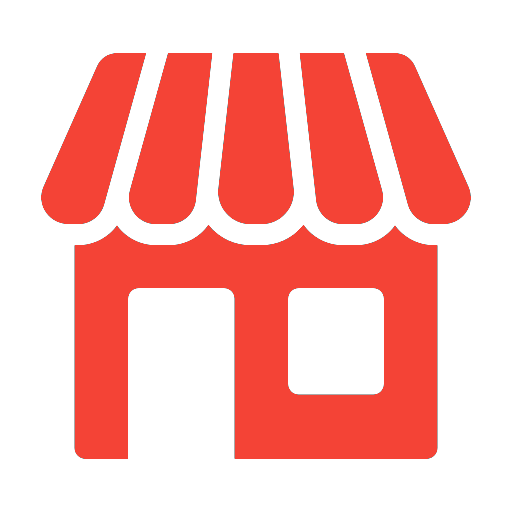
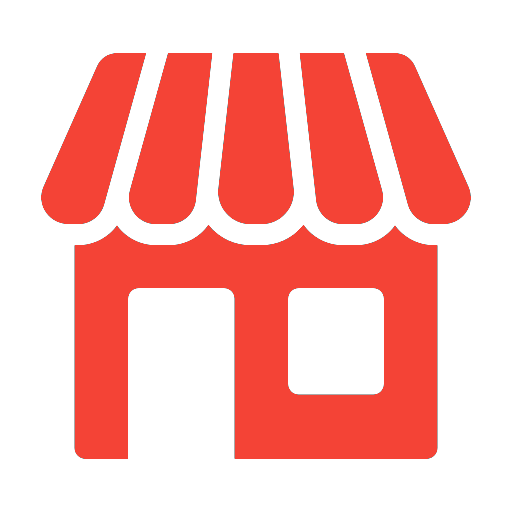
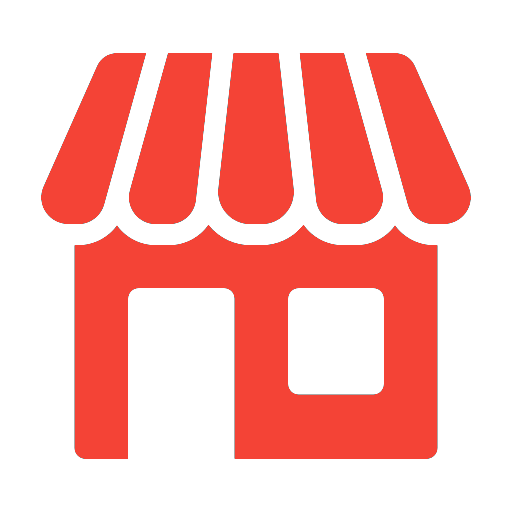
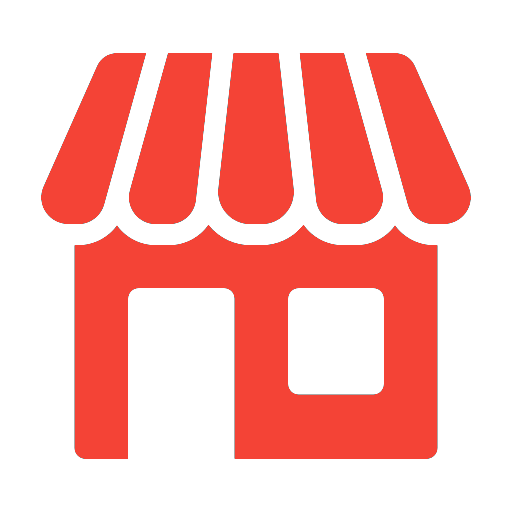
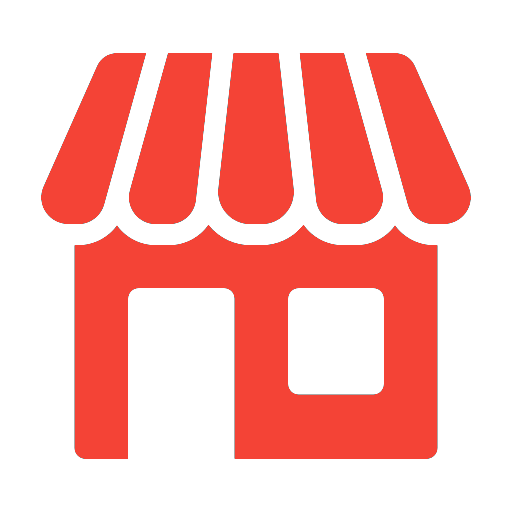
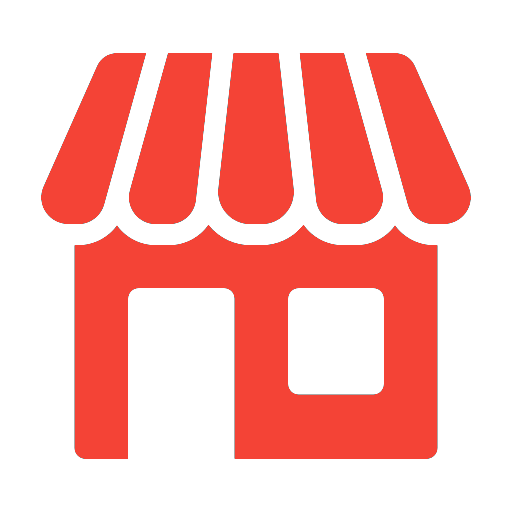
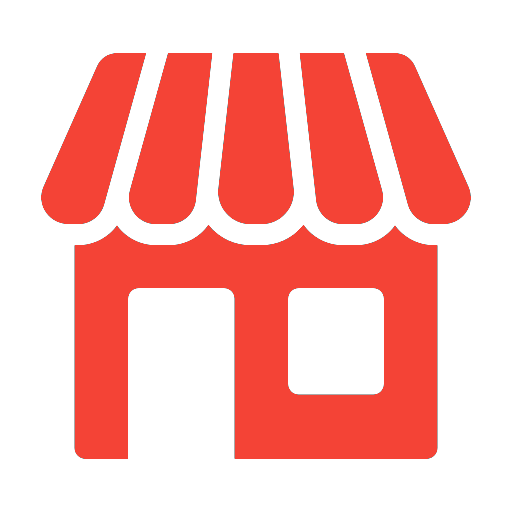
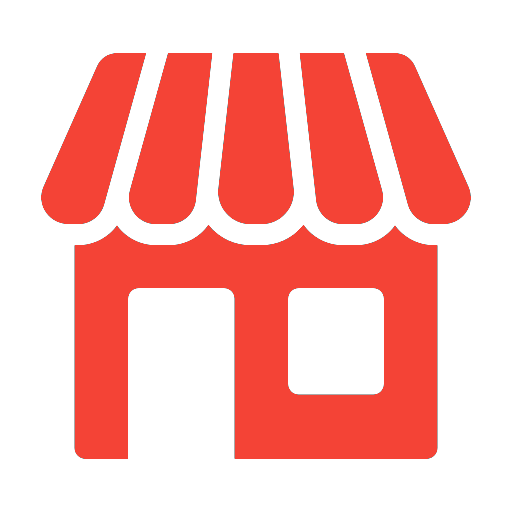
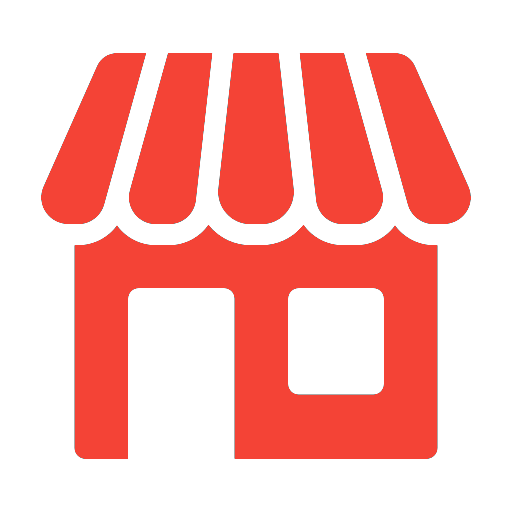
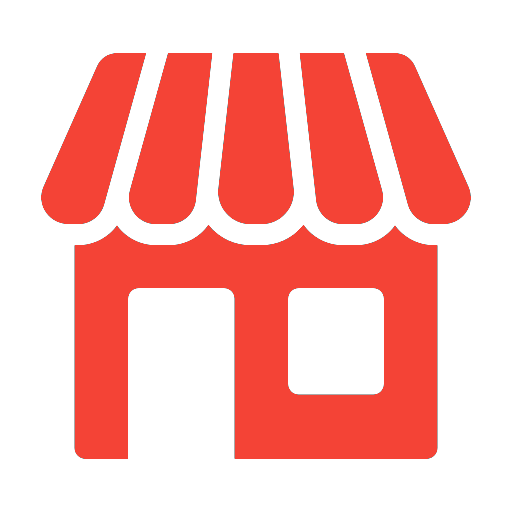
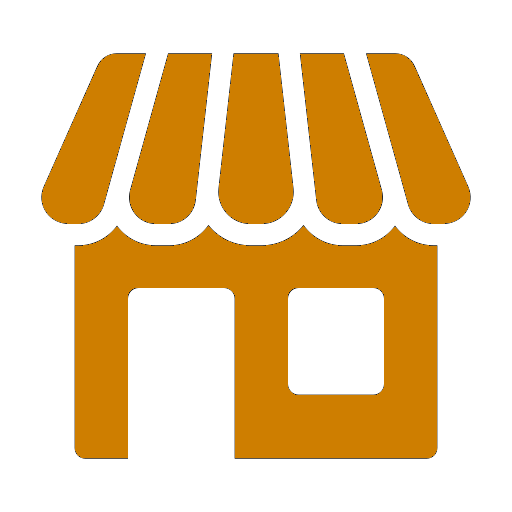
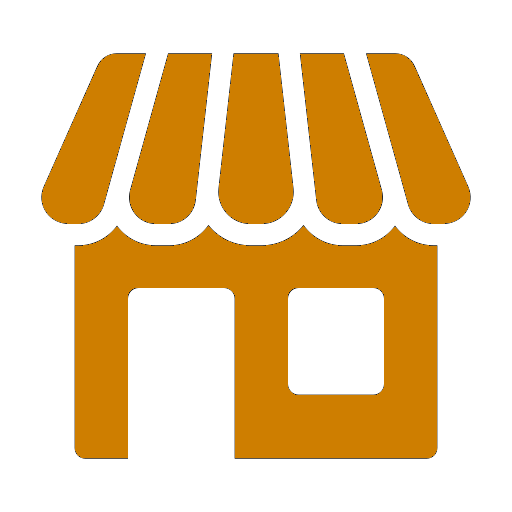
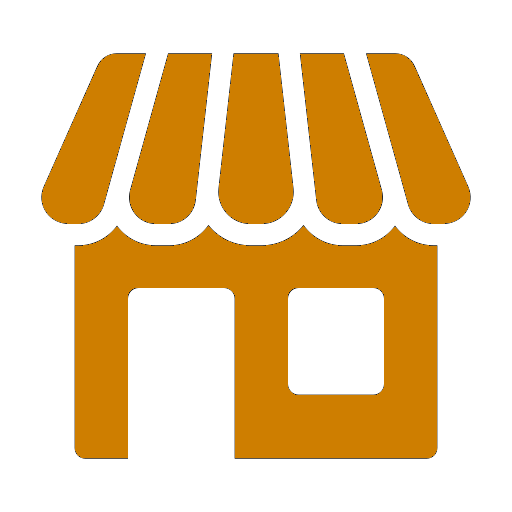
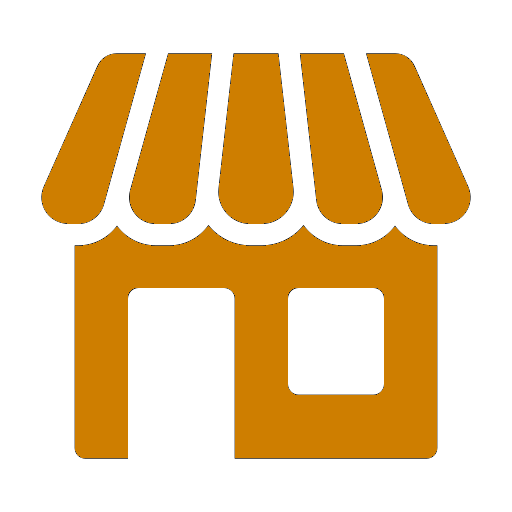
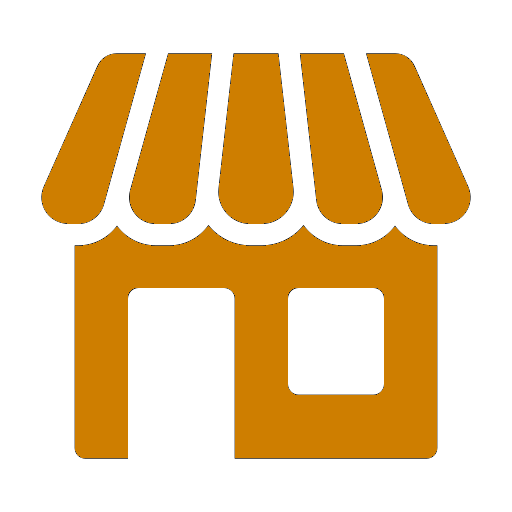
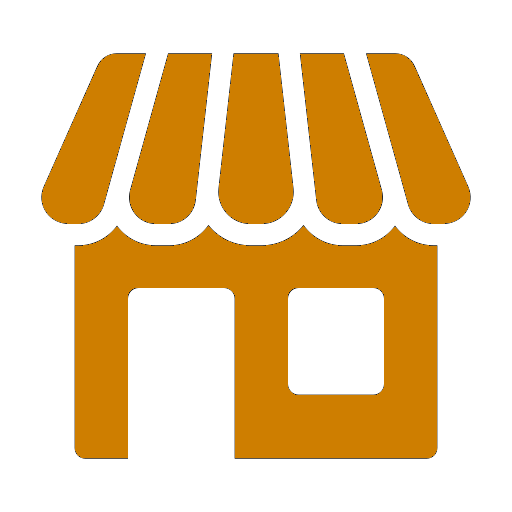
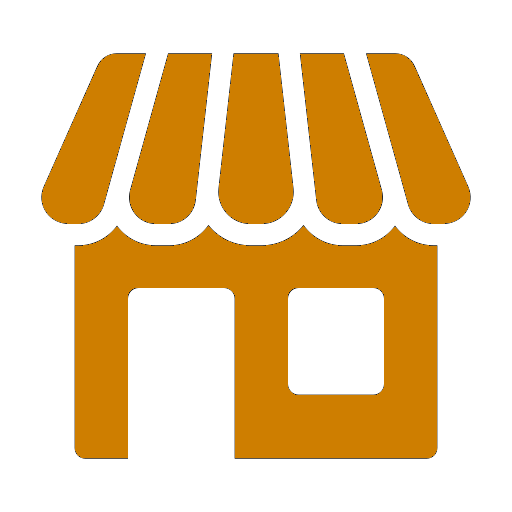
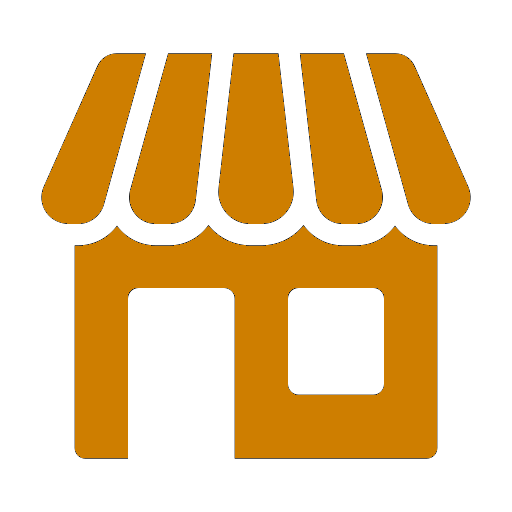
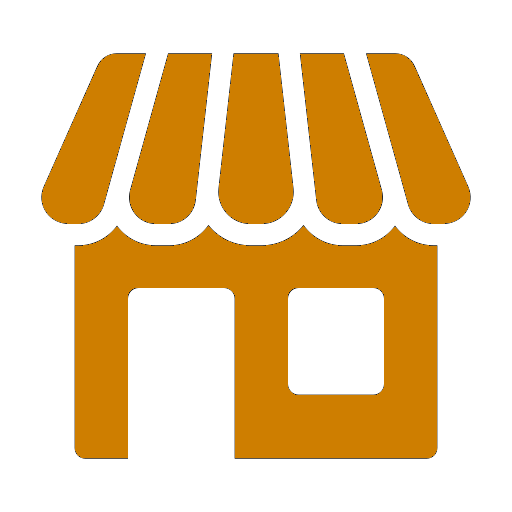
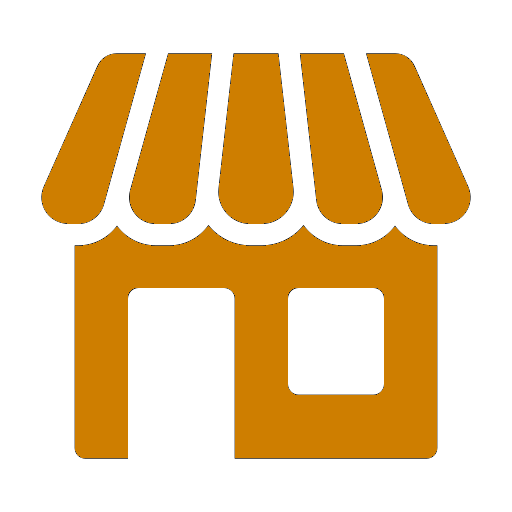
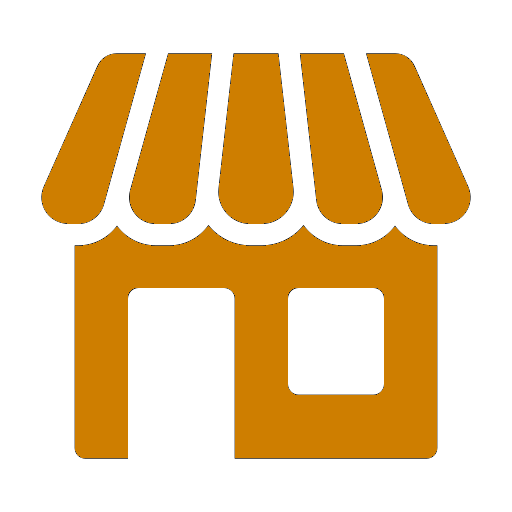
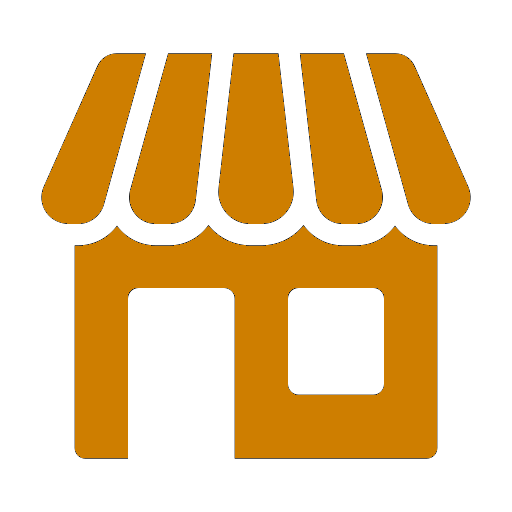
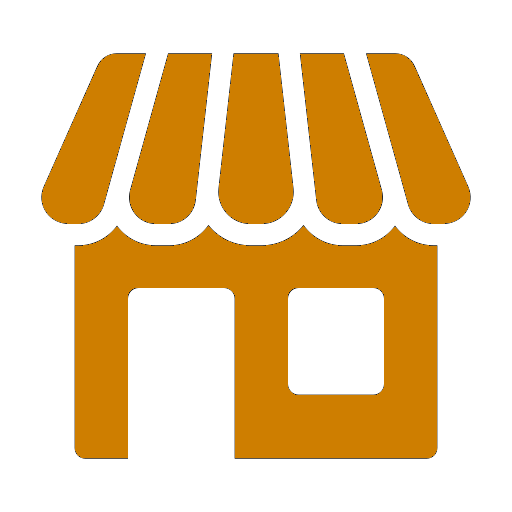
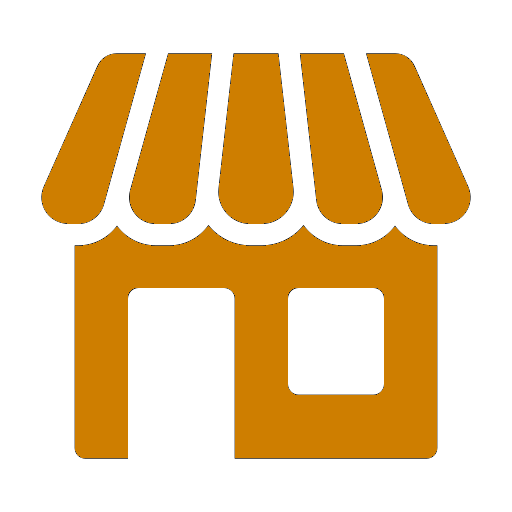
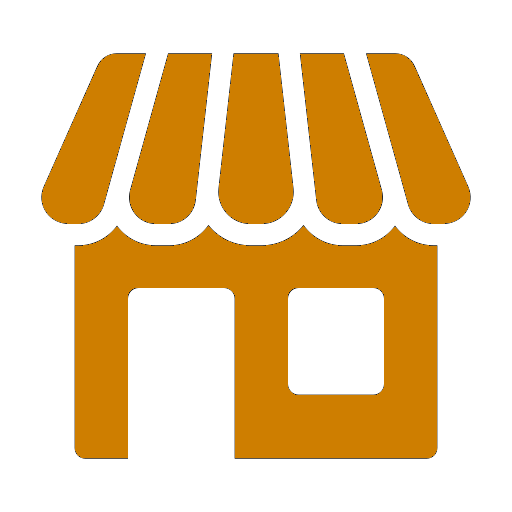
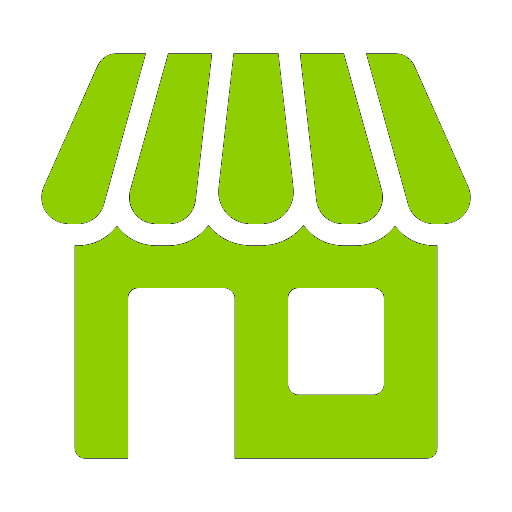
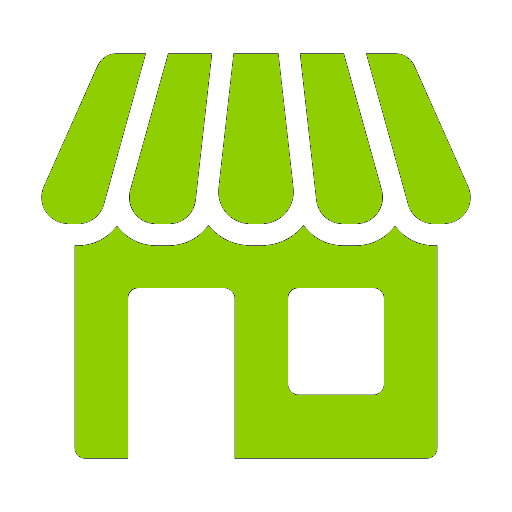
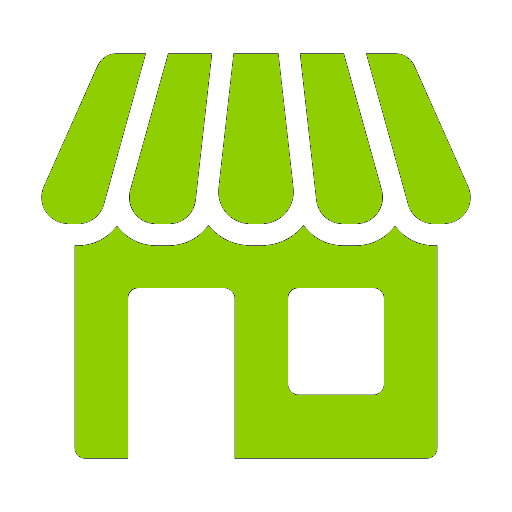
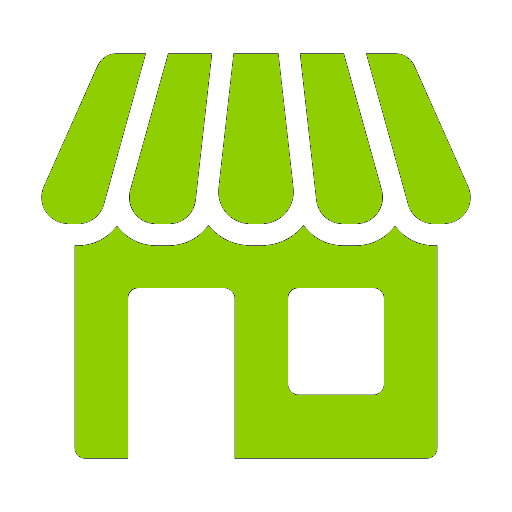
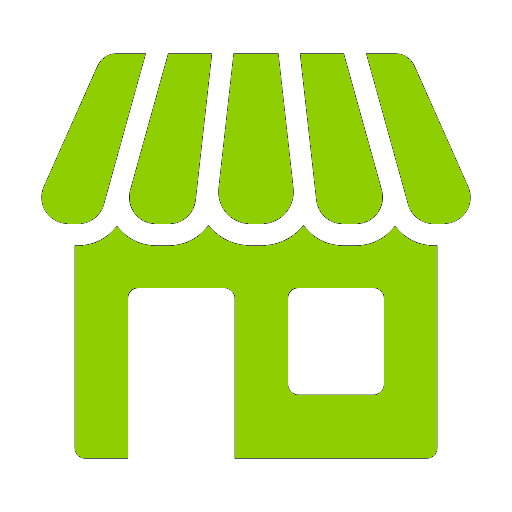
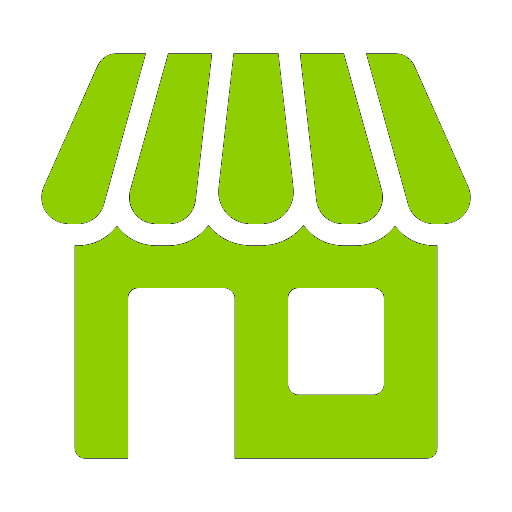
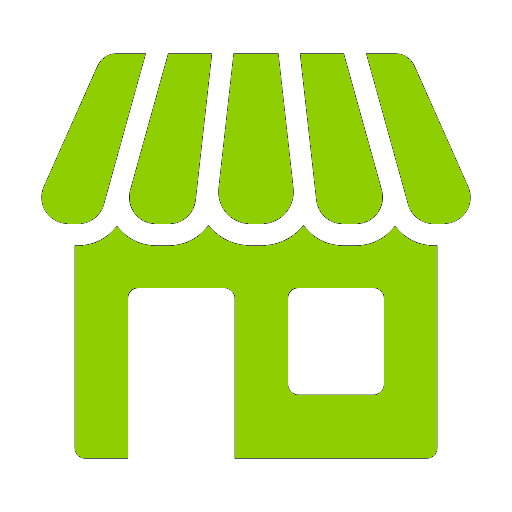
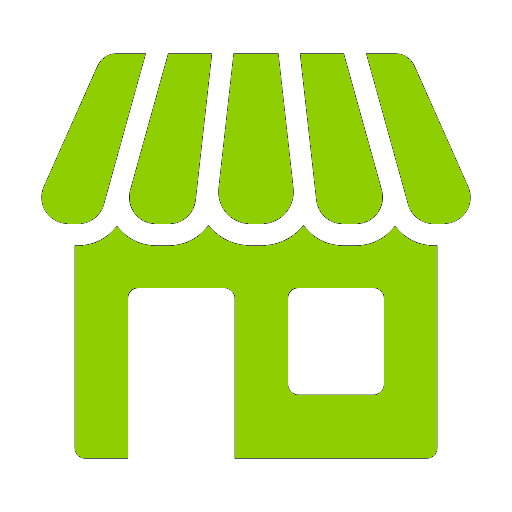
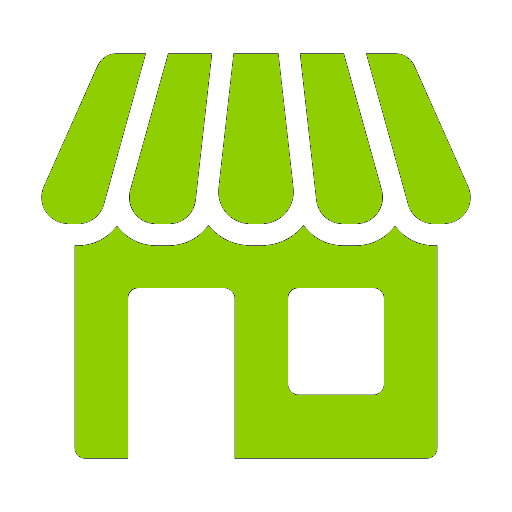
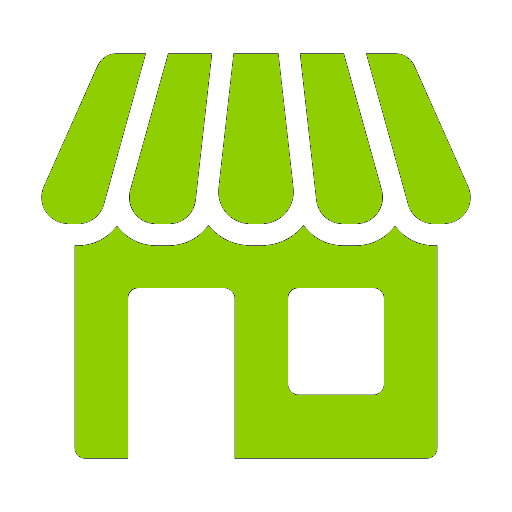
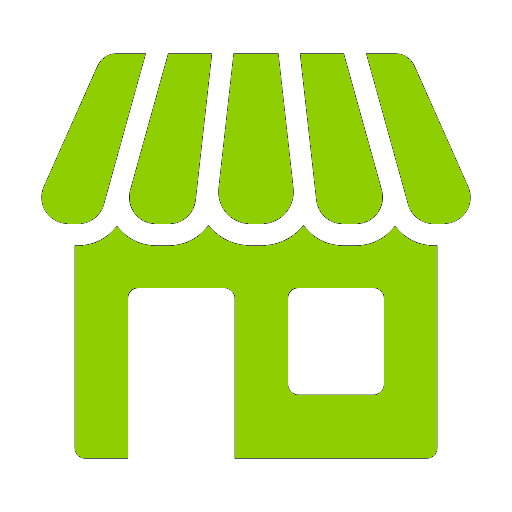
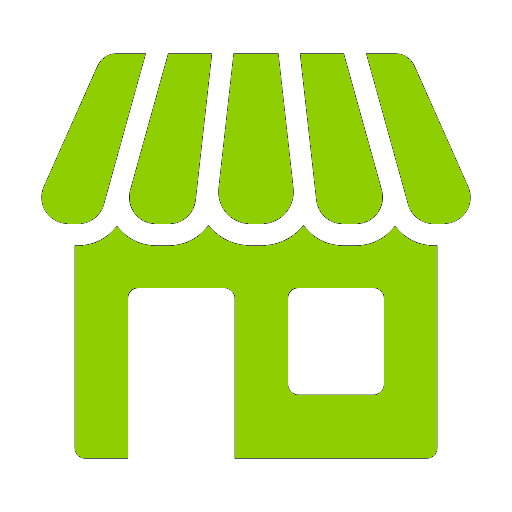
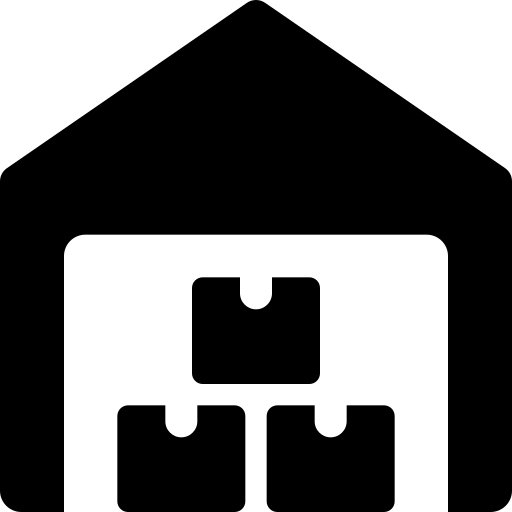

In [22]:
weekday_map = initialise_map(locations)
plot_routes(locations, selected_weekday, weekday_map)